<a href="https://colab.research.google.com/github/oksuzian/Mu2eANL/blob/master/Macros/TrkAnaSU2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Install kerberos

In [ ]:
!apt-get install krb5-user

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  bind9-host geoip-database krb5-config libbind9-160 libdns1100 libgeoip1
  libgssrpc4 libisc169 libisccc160 libisccfg160 libkadm5clnt-mit11
  libkadm5srv-mit11 libkdb5-9 liblwres160
Suggested packages:
  geoip-bin krb5-doc
The following NEW packages will be installed:
  bind9-host geoip-database krb5-config krb5-user libbind9-160 libdns1100
  libgeoip1 libgssrpc4 libisc169 libisccc160 libisccfg160 libkadm5clnt-mit11
  libkadm5srv-mit11 libkdb5-9 liblwres160
0 upgraded, 15 newly installed, 0 to remove and 39 not upgraded.
Need to get 3,848 kB of archives.
After this operation, 15.2 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libisc169 amd64 1:9.11.3+dfsg-1ubuntu1.15 [238 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgeoip1 amd64 1.6.12-1 [71.8 kB]
Get:3 http:/

In [ ]:
!wget https://authentication.fnal.gov/krb5conf/Linux/krb5.conf

--2021-06-24 22:13:41--  https://authentication.fnal.gov/krb5conf/Linux/krb5.conf
Resolving authentication.fnal.gov (authentication.fnal.gov)... 131.225.105.240, 2620:6a:0:105::105:240
Connecting to authentication.fnal.gov (authentication.fnal.gov)|131.225.105.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17486 (17K) [text/plain]
Saving to: ‘krb5.conf’

krb5.conf           100%[===================>]  17.08K  --.-KB/s    in 0.1s    

2021-06-24 22:13:42 (175 KB/s) - ‘krb5.conf’ saved [17486/17486]



In [ ]:
import os
os.environ['KRB5_CONFIG'] = 'krb5.conf'

#Copy files from FNAL

In [ ]:
!kinit oksuzian@FNAL.GOV

Password for oksuzian@FNAL.GOV: 


In [ ]:
!scp -o StrictHostKeyChecking=no -o GSSAPIAuthentication=yes -o GSSAPIDelegateCredentials=yes oksuzian@mu2egpvm04.fnal.gov:/mu2e/data/users/oksuzian/nts.oksuzian.RecoMCTrig.cry3-reco-hi.28PE.pulses.root .
!scp -o StrictHostKeyChecking=no -o GSSAPIAuthentication=yes -o GSSAPIDelegateCredentials=yes oksuzian@mu2egpvm04.fnal.gov:/mu2e/data/users/oksuzian/nts.oksuzian.RecoMCTrig.cry3-reco-lo.28PE.pulses.root .
!scp -o StrictHostKeyChecking=no -o GSSAPIAuthentication=yes -o GSSAPIDelegateCredentials=yes oksuzian@mu2egpvm04.fnal.gov:/mu2e/data/users/oksuzian/ana.cele0s42b2.su2020v2.root .

In [ ]:
!cp ana.*.root drive/MyDrive/root_files_oksuzian/

#Init

In [ ]:
import sys

# This allows you to run on Colaboratory and load files from your Google Drive
try:
    from google.colab import drive
    drive.mount("/content/drive")
    main_path = '/content/drive/My Drive/'
except:
    main_path = ''
sys.path.append(main_path)

Mounted at /content/drive


In [ ]:
%pip install uproot3
%pip install weightwatcher

     |████████████████████████████████| 122kB 23.4MB/s 
     |████████████████████████████████| 92kB 8.9MB/s 
  Created wheel for powerlaw: filename=powerlaw-1.4.6-cp37-none-any.whl size=24789 sha256=6f0f9cda3dcf0892a97b53c21c7cfe0c3f8dd3589e0df5f4196d27e8671f70cd
  Stored in directory: /root/.cache/pip/wheels/e0/27/02/08d0e2865072bfd8d7c655e290521e3feca3fc22f1ac460601
Successfully built powerlaw


In [ ]:
def default_flatname(branchname, fieldname, index):
    """This replaces the dot in the column names with underscores"""
    out = branchname.replace(".", "_")
    if not isinstance(branchname, str):
        out = branchname.decode("utf-8")
    if fieldname is not None:
        fieldname.replace(".", "_")
        out += "_" + fieldname
    if index != ():
        out += "[" + "][".join(str(x) for x in index) + "]"
    return out

In [ ]:
import uproot3
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from plotly import graph_objs as go
import pylab
import seaborn as sns
import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.1f' % x)
plt.style.use('seaborn-whitegrid')
plt.rcParams["grid.linestyle"] = (5,15)
plt.rcParams["grid.linewidth"] = 0.5
plt.rcParams["figure.figsize"] = (10,5)
plt.rcParams.update({'font.size': 22})

#Keras libs
import keras
from keras.models import Sequential, Model, Input
from keras.layers.core import Dense, Activation
from keras.layers import BatchNormalization, Dropout, concatenate
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras.optimizers import Adam
import keras.backend as K

import math
import sklearn.utils
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import brier_score_loss
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score, plot_confusion_matrix
import string
import torchvision.models as models
import weightwatcher as ww
from decimal import Decimal

#Load dataframes

In [ ]:
fileH = uproot3.open("drive/MyDrive/root_files_oksuzian/nts.oksuzian.RecoMCTrig.cry3-reco-hi.28PE.pulses.root")
fileL = uproot3.open("drive/MyDrive/root_files_oksuzian/nts.oksuzian.RecoMCTrig.cry3-reco-lo.28PE.pulses.root")
fileB = uproot3.open("drive/MyDrive/root_files_oksuzian/ana.cele0s42b2.su2020v2.root")

trkanaH = fileH["TrkAnaNeg"]["trkana"]
trkanaL = fileL["TrkAnaNeg"]["trkana"]
trkanaB = fileB["TrkAnaNeg"]["trkana"]

In [ ]:
dfL_eve = trkanaL.pandas.df(['evtinfo.', 'de', 'deent', 'dequal', 'demc', 'trigbits', 'ue', 'crvsummary*'], flatname=default_flatname, flatten=True)
dfL_crv = trkanaL.pandas.df(['crvinfo.*', 'crvinfomc.*', 'bestcrv'], flatname=default_flatname, flatten=True)

dfH_eve = trkanaH.pandas.df(['evtinfo.', 'de', 'deent', 'dequal', 'demc', 'trigbits', 'ue', 'crvsummary*'], flatname=default_flatname, flatten=True)
dfH_crv = trkanaH.pandas.df(['crvinfo.*', 'crvinfomc.*', 'bestcrv'], flatname=default_flatname, flatten=True)

dfB_eve = trkanaB.pandas.df(['evtinfo.', 'de', 'deent', 'dequal', 'demc', 'trigbits', 'ue', 'crvsummary*'], flatname=default_flatname, flatten=True)
dfB_crv = trkanaB.pandas.df(['crvinfo.*', 'crvinfomc.*', 'bestcrv'], flatname=default_flatname, flatten=True)

dfL_crv = dfL_crv[dfL_crv.index.get_level_values('subentry') == dfL_crv["bestcrv"]]
dfH_crv = dfH_crv[dfH_crv.index.get_level_values('subentry') == dfH_crv["bestcrv"]]
dfB_crv = dfB_crv[dfB_crv.index.get_level_values('subentry') == dfB_crv["bestcrv"]]

pd.merge(dfL_eve, dfL_crv, how="left", on='entry')
dfL = dfL_eve.merge(dfL_crv, how="left", on="entry")
dfH = dfH_eve.merge(dfH_crv, how="left", on="entry")
dfB = dfB_eve.merge(dfB_crv, how="left", on="entry")

dfH['is_high'] = 1
dfL['is_high'] = 0
dfB['is_high'] = -1

df = pd.concat([dfH, dfL, dfB], axis=0)
df["crvinfo__dT"] = df["crvinfo__timeWindowStart"] - df["de_t0"]
df['deent_d0_om'] = df["deent_d0"]+2.0/df["deent_om"]
df["is_triggered"] = (df["trigbits"].values & 0x208) > 0

df = df.fillna(-999999)


INFO:numexpr.utils:NumExpr defaulting to 2 threads.


In [ ]:
del dfB_eve, dfB_crv, dfL_eve, dfL_crv, dfH_eve, dfH_crv, dfH, dfL, dfB

In [ ]:
#del dfH, dfL, dfB

In [ ]:
#df.to_hdf('drive/MyDrive/root_files/cosmic_ce_cominded.h5', key='df', mode='w')
#pd.read_hdf('drive/MyDrive/root_files/cosmic_ce_cominded.h5', 'df')

#Define cuts

In [ ]:
#Default MDC-style cut box
cuts = [
    "(de_status > 0)",
    "(deent_td > 0.577350)",
    "(deent_td < 1.000)",
    "(deent_d0 > -80)",
    "(deent_d0 < 105)",
    "((deent_d0 + 2./deent_om) > 450)",
    "((deent_d0 + 2./deent_om) < 680)",
    "(is_triggered)"
]
cut_tbox = " & ".join(cuts)
#PID, TrkQual and cut on events with an usptream leg
cuts = [
    "(dequal_TrkQual > 0.8)",
    "(dequal_TrkPID > 0.95)",
    "(ue_status <= 0)"
]
cut_pid_trkqual_ue = " & ".join(cuts)
# Extended momentum window cut`
cuts = [
    "(deent_mom > 100)",
    "(deent_mom < 110)"
]
cut_extmom = " & ".join(cuts)
# Loose box cuts
cuts = [
    "(deent_td > 0.577350)",
    "(deent_td < 1.000)",
    "(deent_d0 > -80)",
    "(deent_d0 < 205)",
    "((deent_d0 + 2./deent_om) > 450)",
    "(is_triggered)"
]

crv_time = "((-de_t0 + crvinfo__timeWindowStart) > 50 | (de_t0-crvinfo__timeWindowStart) > 150.0)"

#crv_time = "de_t0-crvinfo__timeWindowStart > 350.0"


cut_lbox = " & ".join(cuts)

cut_lbox = " & ".join(cuts)


In [ ]:
#Combime cuts
cut_nomom  = cut_tbox +" & "+cut_pid_trkqual_ue
cut_extmom = cut_tbox +" & "+cut_pid_trkqual_ue+" & "+cut_extmom
cut_loose  = cut_lbox +" & "+cut_pid_trkqual_ue

In [ ]:
df_cut_nomom = df.query(cut_nomom)
df_cut_extmom = df.query(cut_extmom)
df_cut_loose = df.query(cut_loose)
df_time = df.query(crv_time + " & " + cut_nomom)

In [ ]:
no = len((df_cut_nomom[(df_cut_nomom["is_high"]==1) | (df_cut_nomom["is_high"] == 0)]))
noN = len(df_cut_nomom[df_cut_nomom["is_high"] == -1])

ex = len((df_cut_extmom[(df_cut_extmom["is_high"]==1) | (df_cut_extmom["is_high"] == 0)]))
exN = len(df_cut_extmom[df_cut_extmom["is_high"] == -1])

lo = len((df_cut_loose[(df_cut_loose["is_high"]==1) | (df_cut_loose["is_high"] == 0)]))
loN = len(df_cut_loose[df_cut_loose["is_high"] == -1])

time = len(df_time[(df_time["is_high"] == 1) | (df_time["is_high"]==0)])
timeN = len(df_time[df_time["is_high"]== -1])

tot = len(df[(df["is_high"] == 1) | (df["is_high"] == 0)])
totN = len(df[df["is_high"] == -1])

print("Number of cosmics that exist:", tot)
print("Number of CEs that exist:", totN)
print("-"*25,"combined cuts","-"*25)
print("Number of cosmics found with no time or momentum cuts:", no)
print("Cosmic veto efficiency without CRV:", 1-no/tot)
print()
print("Number of CEs found with no time or momentum cuts:", noN)
print("CE Efficiency:", noN/totN)

print("-"*25,"time cut","-"*25)
print("Number of cosmics found with time cut:", time)
print("Cosmic veto efficiency with CRV:", 1 - time/tot)
print()
print("Number of CEs found with time cut:", timeN)
print("CE Reconstruction Effiency:", timeN/totN)

Number of cosmics that exist: 1842456
Number of CEs that exist: 2385473
------------------------- combined cuts -------------------------
Number of cosmics found with no time or momentum cuts: 36739
Cosmic veto efficiency without CRV: 0.980059768048735

Number of CEs found with no time or momentum cuts: 1574589
CE Efficiency: 0.6600741236643635
------------------------- time cut -------------------------
Number of cosmics found with time cut: 110
Cosmic veto efficiency with CRV: 0.9999402970817214

Number of CEs found with time cut: 1427465
CE Reconstruction Effiency: 0.598399143482236


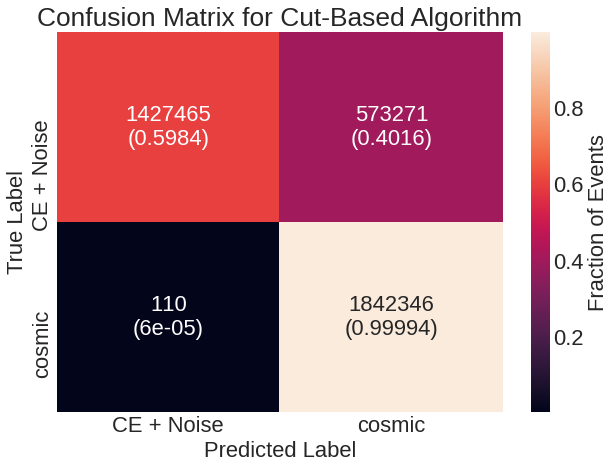

In [ ]:
cutsMatrix = np.array([[timeN/totN, (1-timeN/totN)], [time/tot, (1 - time/tot)]])
plt.figure(figsize=(10,7));
 
annotStr = annot=np.array([[str(round(timeN)) + '\n(' + str(round(timeN/totN,5)) + ')', str(round((1-timeN/totN)*timeN)) + '\n(' + str(round(1-timeN/totN,5)) + ')'], [str(round(time)) + '\n(' + str(round(time/tot,5)) + ')', str(round((1 - time/tot)*tot)) + '\n(' + str(round(1 - time/tot,5)) + ')']])

ax = sns.heatmap(cutsMatrix, annot = annotStr, xticklabels=["CE + Noise", "cosmic"], yticklabels=["CE + Noise", "cosmic"], fmt='.17s', cbar_kws={'label': 'Fraction of Events'});
 
ax.set(title="Confusion Matrix for Cut-Based Algorithm",
      xlabel="Predicted Label",
      ylabel="True Label",);

#Define variables list

In [ ]:
all_variables_list = {'crvinfo__x': [-8000, 1000], 
                  'crvinfo__y': [0, 3500],
                  'crvinfo__z': [-5000, 20000],
                  'de_nhits': [-2, 100],
                  'ue_nhits': [-2, 100],
                  'dequal_TrkPID': [-1.1, 1.1],
                  'dequal_TrkQual': [-0.1, 1.1],
                  'deent_td': [0, 10],
                  'deent_z0': [-500,500],
                  'deent_d0': [-500,500],
                  'deent_om': [-0.01, 0.05],
                  'crvinfo__PEs': [-1, 1000],
                  'crvinfo__dT': [-500, 500],
                  'deent_mom': [50, 200],
                  'deent_d0_om' : [300, 1200]
                  }

In [ ]:
Z_variables_list = {
                  'de_nhits': [-2, 100],
                  'ue_nhits': [-2, 100],
                  'dequal_TrkPID': [-1.1, 1.1],
                  'dequal_TrkQual': [-0.1, 1.1],
                  'deent_td': [0, 10],
                  'deent_z0': [-500,500],
                  'deent_d0': [-500,500], #only z as the crv variable
                  'deent_om': [-0.01, 0.05],
                  'deent_mom': [50, 200],
                  'deent_d0_om' : [300, 1200],
                  'crvinfo__z': [-5000, 20000]
                  }

In [ ]:
dT_variables_list = {
                  'de_nhits': [-2, 100],
                  'ue_nhits': [-2, 100],
                  'dequal_TrkPID': [-1.1, 1.1],
                  'dequal_TrkQual': [-0.1, 1.1], #only dT as the crv variable
                  'deent_td': [0, 10],
                  'deent_z0': [-500,500],
                  'deent_d0': [-500,500],
                  'deent_om': [-0.01, 0.05],
                  'crvinfo__dT': [-500, 500],
                  'deent_mom': [50, 200],
                  'deent_d0_om' : [300, 1200]
                  }

In [ ]:
dTZ_variables_list = {
                  'de_nhits': [-2, 100],
                  'ue_nhits': [-2, 100],
                  'dequal_TrkPID': [-1.1, 1.1],
                  'dequal_TrkQual': [-0.1, 1.1],
                  'deent_td': [0, 10],
                  'deent_z0': [-500,500],
                  'deent_d0': [-500,500],
                  'deent_om': [-0.01, 0.05],
                  'crvinfo__dT': [-500, 500],
                  'deent_mom': [50, 200],
                  'deent_d0_om' : [300, 1200],
                  'crvinfo__z': [-5000, 20000]
                  }

In [ ]:
dTZPE_noMom_variables_list = {
                  'crvinfo__z': [-5000, 20000],
                  'crvinfo__PEs': [-1, 1000],
                  'crvinfo__dT': [-500, 500],
                  'de_nhits': [-2, 100],
                  'ue_nhits': [-2, 100],
                  'dequal_TrkPID': [-1.1, 1.1],
                  'dequal_TrkQual': [-0.1, 1.1],
                  'deent_td': [0, 10],
                  'deent_z0': [-500,500],
                  'deent_d0': [-500,500],
                  'deent_om': [-0.01, 0.05],
                  'deent_d0_om' : [300, 1200]
                  }

In [ ]:
noCRV_noMom_variables_list = {
                  'de_nhits': [-2, 100],
                  'ue_nhits': [-2, 100],
                  'dequal_TrkPID': [-1.1, 1.1],
                  'dequal_TrkQual': [-0.1, 1.1],
                  'deent_td': [0, 10],
                  'deent_z0': [-500,500],
                  'deent_d0': [-500,500],
                  'deent_om': [-0.01, 0.05],
                  'deent_d0_om' : [300, 1200]
                  }

In [ ]:
translation = {'crvinfo__x': "x position", 
                  'crvinfo__y': "y position",
                  'crvinfo__z': "z position",
                  'de_nhits': "Downstream tracker hits",
                  'ue_nhits': "Upstream tracker hits",
                  'dequal_TrkPID': "Particle ID", #calorimeter
                  'dequal_TrkQual': "Track Quality",
                  'deent_td': "Pitch Angle", #z axis
                  'deent_z0': "z0 of track",
                  'deent_d0': "distance from z axis",
                  'deent_om': 'Min transverse radius',
                  'crvinfo__PEs': "PE yield",
                  'crvinfo__dT': "Delta-T = T_crv - T_tracker",
                  'deent_mom': "Momentum",
                  'deent_d0_om' : 'Max transverse radius'
                  }

#Make plots

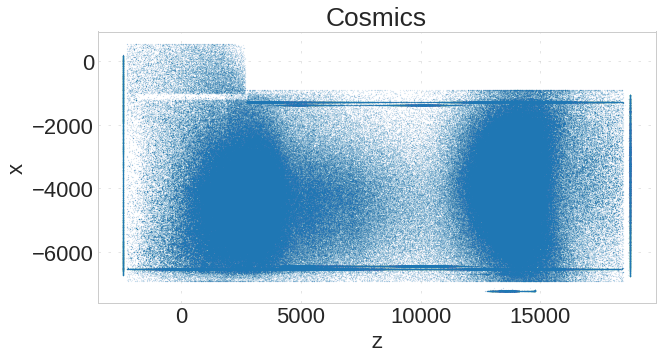

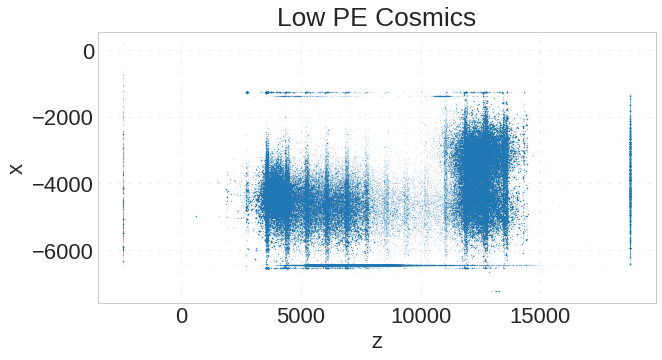

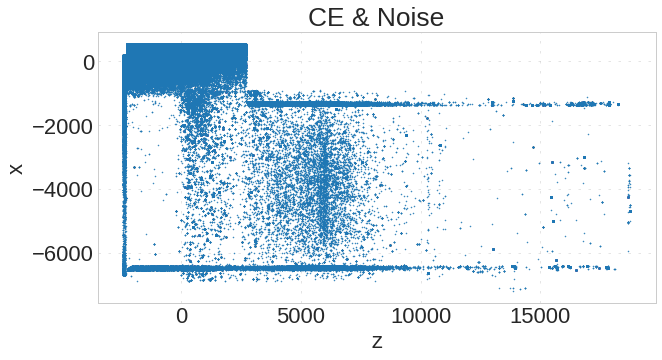

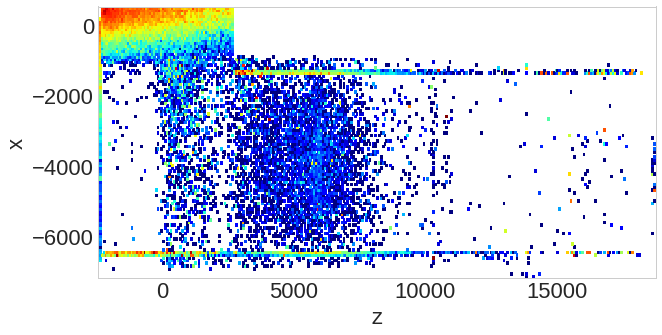

In [ ]:
import matplotlib as mpl

plt.plot(df.query('is_high == 1 & crvinfo__timeWindowStart>0')['crvinfomc__z'], df.query('is_high == 1 & crvinfo__timeWindowStart>0')['crvinfomc__x'], '.', markersize=0.1);
plt.title("Cosmics");
plt.xlabel("z");
plt.ylabel("x");
plt.figure()
plt.plot(df.query('is_high == 0 & crvinfo__timeWindowStart>0')['crvinfomc__z'], df.query('is_high == 0 & crvinfo__timeWindowStart>0')['crvinfomc__x'], '.', markersize=0.1);
plt.title("Low PE Cosmics");
plt.xlabel("z");
plt.ylabel("x");
plt.figure()
plt.plot(df.query('is_high == -1 & crvinfo__timeWindowStart>0')['crvinfomc__z'], df.query('is_high == -1 & crvinfo__timeWindowStart>0')['crvinfomc__x'], '.', markersize=1.0);
plt.title("CE & Noise");
plt.xlabel("z");
plt.ylabel("x");
plt.figure()
plt.hist2d(df.query('is_high == -1 & crvinfo__timeWindowStart>0')['crvinfomc__z'], df.query('is_high == -1 & crvinfo__timeWindowStart>0')['crvinfomc__x'], bins=(300, 100), norm=mpl.colors.LogNorm(), cmap = plt.cm.jet);
plt.xlabel("z");
plt.ylabel("x");


In [ ]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

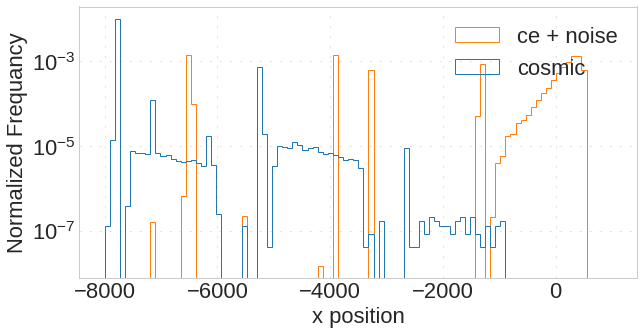

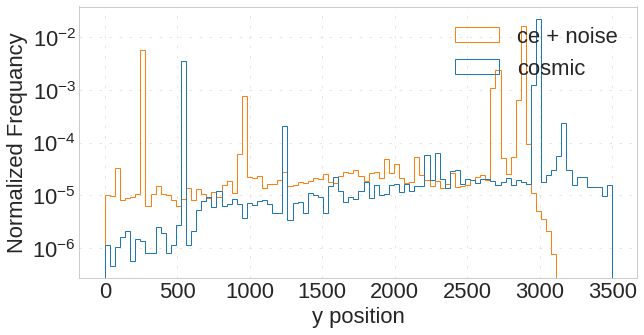

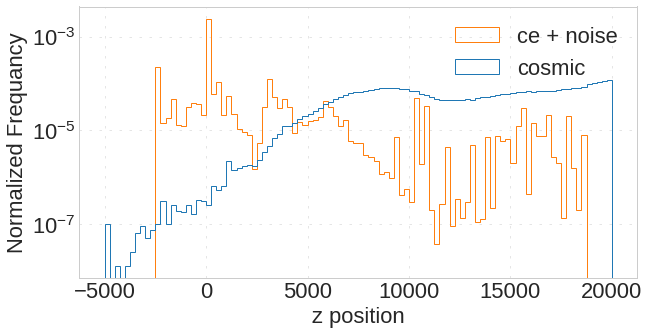

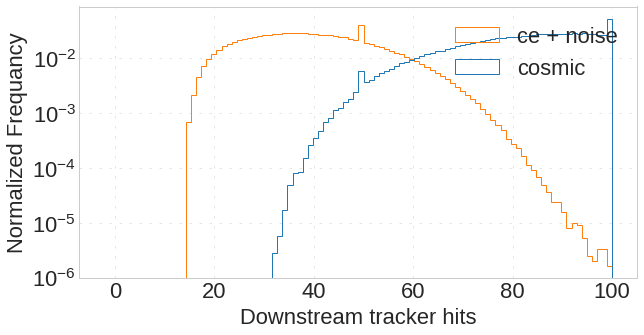

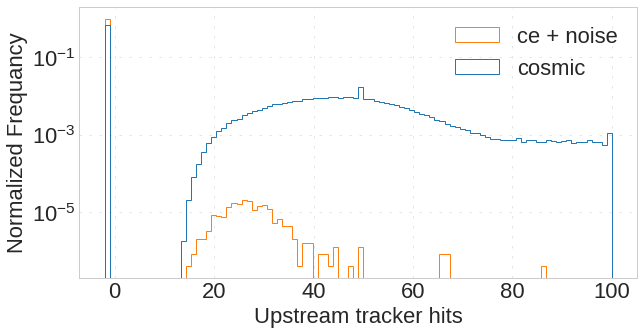

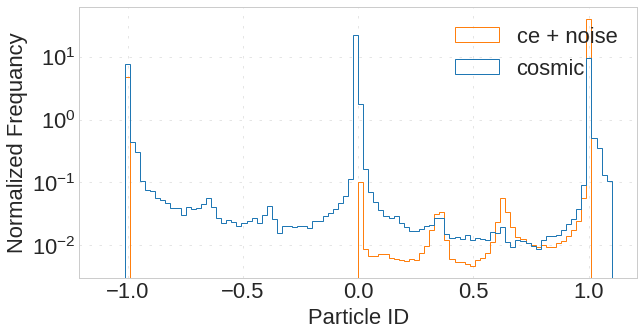

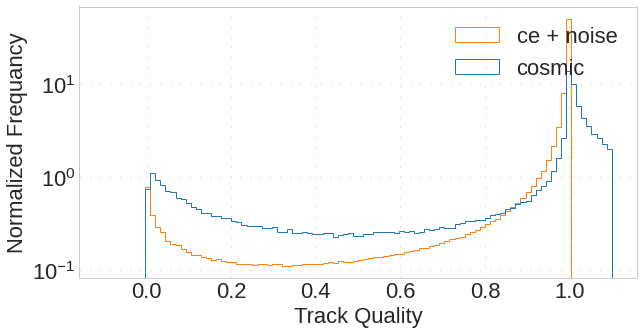

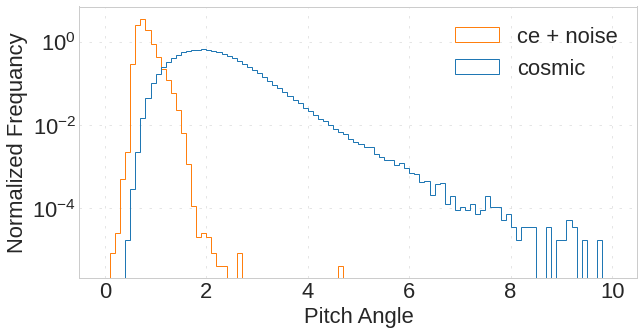

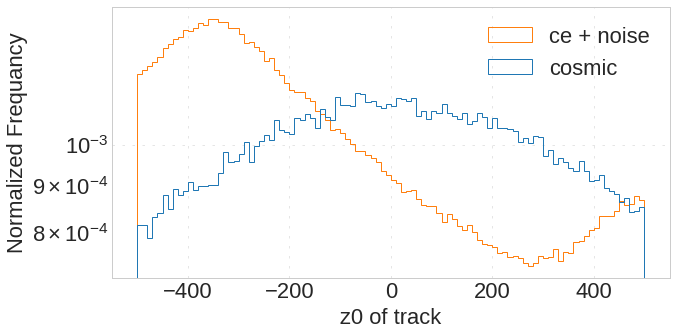

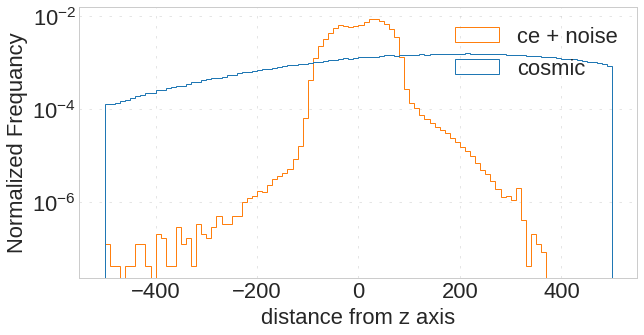

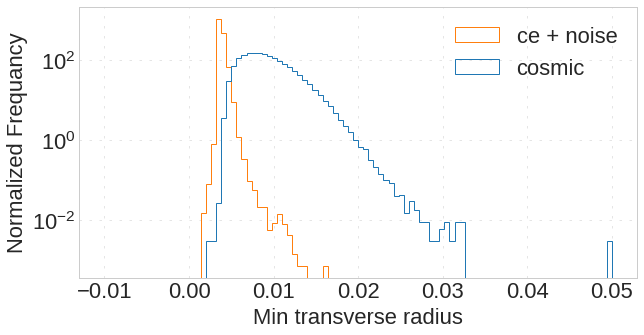

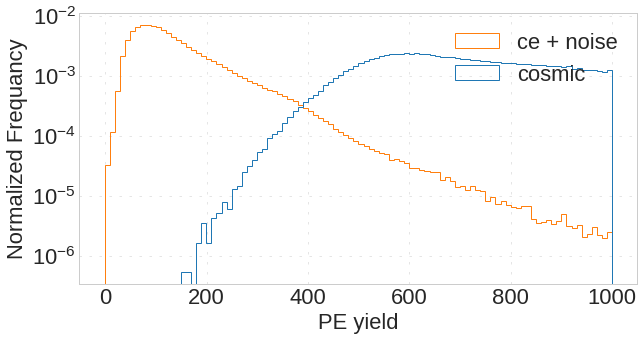

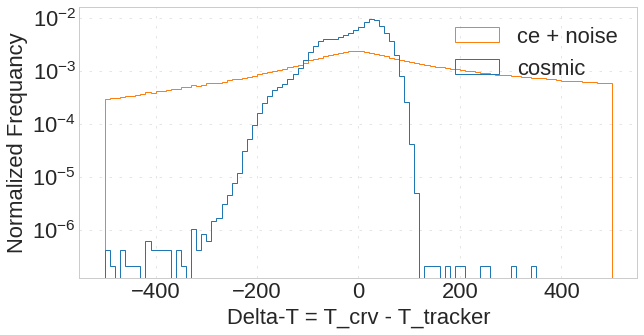

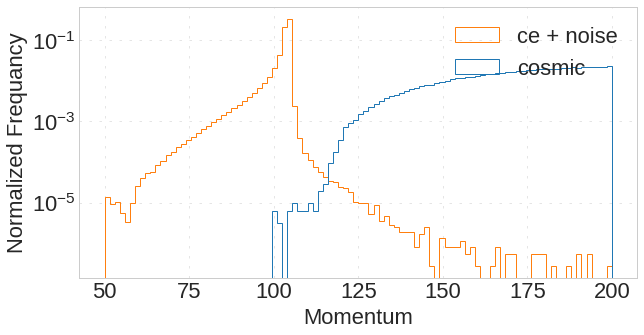

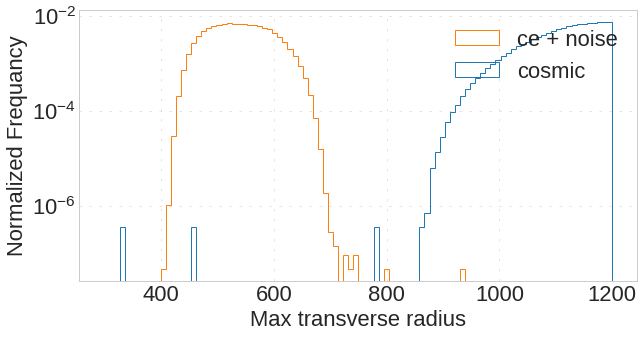

<Figure size 720x360 with 0 Axes>

In [ ]:
for var in all_variables_list:
#  plt.hist([df.query('is_high == 0').query(cut_loose)[var], df.query('is_high == 1').query(cut_loose)[var]], bins=100, histtype='step', range=variables_list[var], label=['lo', 'hi'], density=True);
  plt.hist([df.query('is_high == 0')[var] + df.query('is_high == 1')[var], df.query('is_high == -1')[var]], bins=100, histtype='step', range=all_variables_list[var], label=['cosmic', 'ce + noise'], density=True);
  plt.xlabel(translation[var])
  plt.yscale('log')
  plt.legend()
  plt.ylabel('Normalized Frequancy')
  plt.figure()

#Fix and Create New Data

In [ ]:
def toBinary(val):
  if val == 1 or val == 0:
    return 1
  else:
    return 0

In [ ]:
def smear(arr):
  for i in arr:
    if i[1] == 1 or i[0] < -2500:
      continue
    x = -9999999
    while x < -2500 or x > 19000:
      x = np.random.normal(i[0], 500)
    i[0] = x
  return arr

In [ ]:
variables_list = dTZPE_noMom_variables_list

In [ ]:
variables_columns = list(variables_list.keys())
variables_columns.append('is_high')
MLDF = df[variables_columns]
MLDF['is_cosmic'] = MLDF['is_high'].apply(toBinary)
MLDF.drop(columns='is_high', inplace=True)
zz = smear(MLDF[['crvinfo__z','is_cosmic']].to_numpy()) #only use this cell if operating on crv variables
oldZNoise = MLDF['crvinfo__z'][MLDF['is_cosmic']==0]
MLDF['crvinfo__z'], MLDF['is_cosmic'] = zz[:,0], zz[:,1]

In [ ]:
noCRV = MLDF[(MLDF['crvinfo__PEs']<=-2500)] #Data Filtration
noCRV.drop(['crvinfo__z', 'crvinfo__PEs', 'crvinfo__dT'], axis=1, inplace=True)

In [ ]:
onlyCRV = MLDF[(MLDF['crvinfo__PEs']>=0)] #Data Filtration

In [ ]:
# CE_events = MLDF[MLDF['is_cosmic']==0].to_numpy()
# crvinfo = CE_events[:,[0,1,2]]
# trackinginfo = CE_events[:,3:]
# np.random.shuffle(crvinfo)
# np.random.shuffle(trackinginfo)
# newNoise = np.concatenate((crvinfo, trackinginfo), 1)
# newNoiseDF = pd.DataFrame(newNoise, columns=MLDF.columns)
# MLDF = MLDF.append(newNoiseDF, ignore_index=True)

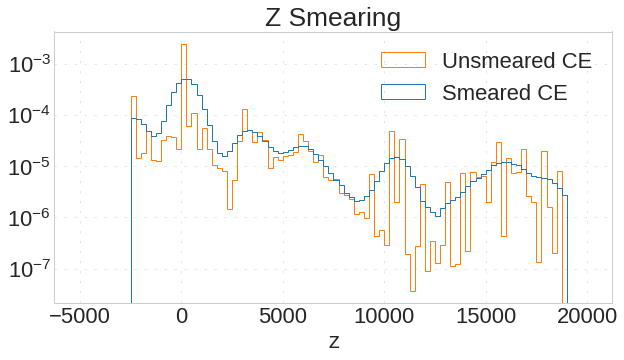

In [ ]:
plt.hist([MLDF['crvinfo__z'][MLDF['is_cosmic']==0],oldZNoise], bins=100, histtype='step', range=variables_list['crvinfo__z'], density=True, label=["Smeared CE", "Unsmeared CE"]);
plt.yscale('log');
plt.xlabel("z");
plt.title("Z Smearing");
plt.legend(loc='best');

#Create Training, Validation, and Testing Data

In [ ]:
y = MLDF['is_cosmic']
X = MLDF.drop(columns='is_cosmic')
X_train_df, X_test_df, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train_df, X_val_df, y_train, y_val = train_test_split(X_train_df, y_train, test_size=0.25, random_state=1)
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)
y_val = np.ravel(y_val)
scaler = StandardScaler().fit(X)
X_train = scaler.transform(X_train_df)
X_test = scaler.transform(X_test_df)
X_val = scaler.transform(X_val_df)

In [ ]:
y_noCRV = noCRV['is_cosmic']
X_noCRV = noCRV.drop(columns='is_cosmic')
noCRV_X_train_df, no_CRV_X_test_df, noCRV_y_train, noCRV_y_test = train_test_split(X_noCRV, y_noCRV, test_size=0.2, random_state=1)
noCRV_X_train_df, noCRV_X_val_df, noCRV_y_train, noCRV_y_val = train_test_split(noCRV_X_train_df, noCRV_y_train, test_size=0.25, random_state=1)
noCRV_y_train = np.ravel(noCRV_y_train)
no_CRV_y_test = np.ravel(noCRV_y_test)
noCRV_y_val = np.ravel(noCRV_y_val)
scaler = StandardScaler().fit(X_noCRV)
noCRV_X_train = scaler.transform(noCRV_X_train_df)
no_CRV_X_test = scaler.transform(no_CRV_X_test_df)
noCRV_X_val = scaler.transform(noCRV_X_val_df)

In [ ]:
y_CRV = onlyCRV['is_cosmic']
X_CRV = onlyCRV.drop(columns='is_cosmic')
CRV_X_train_df, CRV_X_test_df, CRV_y_train, CRV_y_test = train_test_split(X_CRV, y_CRV, test_size=0.2, random_state=1)
CRV_X_train_df, CRV_X_val_df, CRV_y_train, CRV_y_val = train_test_split(CRV_X_train_df, CRV_y_train, test_size=0.25, random_state=1)
CRV_y_train = np.ravel(CRV_y_train)
CRV_y_test = np.ravel(CRV_y_test)
CRV_y_val = np.ravel(CRV_y_val)
scaler = StandardScaler().fit(X_CRV)
CRV_X_train = scaler.transform(CRV_X_train_df)
CRV_X_test = scaler.transform(CRV_X_test_df)
CRV_X_val = scaler.transform(CRV_X_val_df)

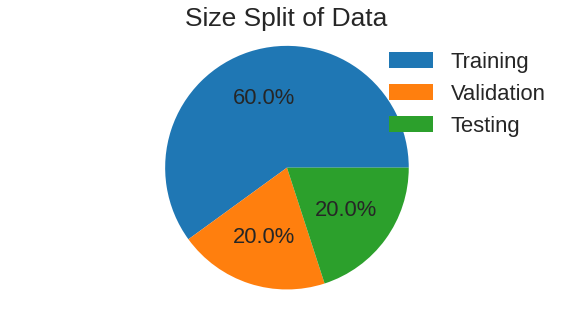

In [ ]:
labels = "Training","Validation","Testing"
sizes = len(X_train)/len(X), len(X_val)/len(X), len(X_test)/len(X)
plt.pie(sizes, labels=labels, autopct='%1.1f%%', labeldistance=None);
plt.legend();
plt.gca().axis('equal');
plt.title("Size Split of Data");

#Make correlation plots

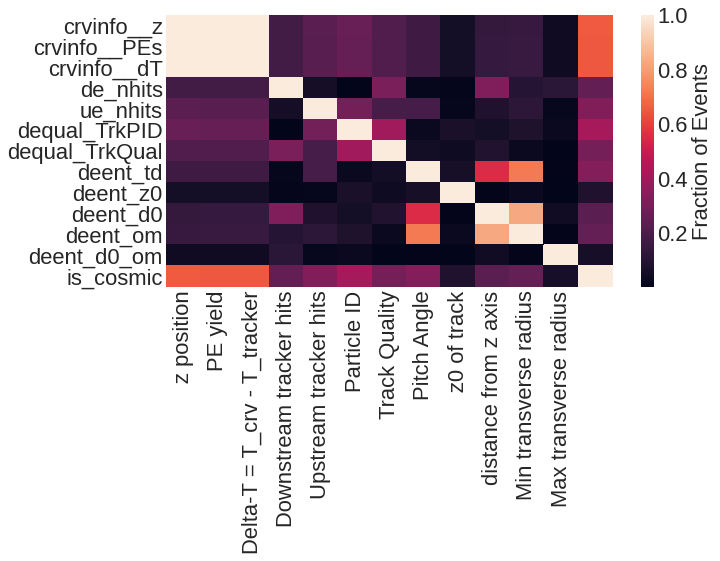

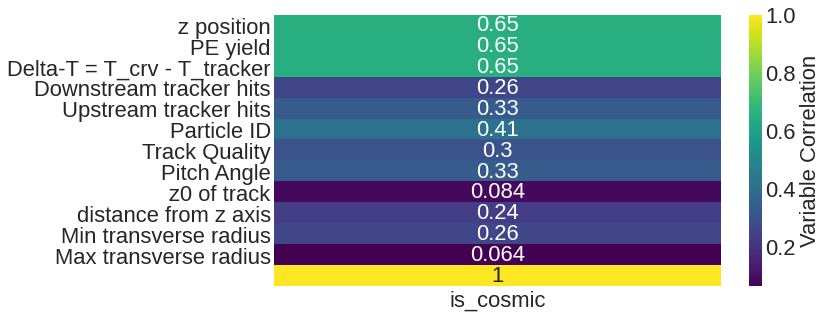

In [ ]:
import seaborn as sns
corr = MLDF.corr();
sns.heatmap(abs(corr), xticklabels=list(map(translation.get, corr.columns.values)), yticklabels=corr.columns.values, cbar_kws={'label': 'Fraction of Events'});
plt.figure();
sns.heatmap(abs(corr[['is_cosmic']]), yticklabels=list(map(translation.get, corr.columns.values)), fmt='.2g', cmap='viridis', annot=True, cbar_kws={'label': 'Variable Correlation'});

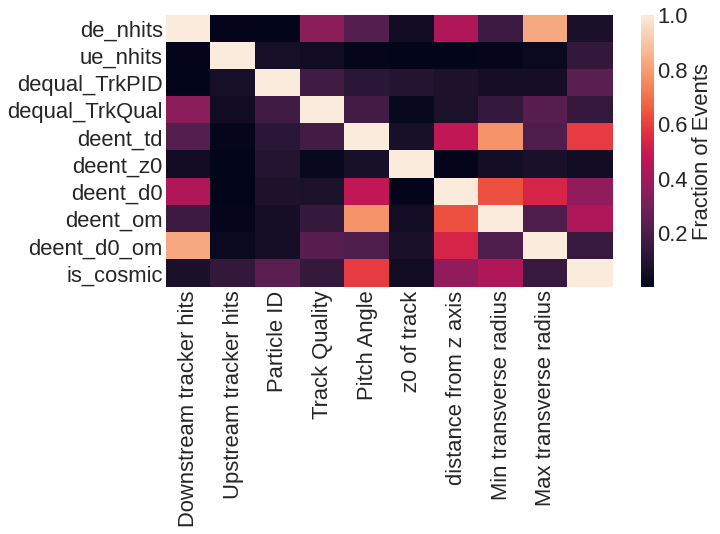

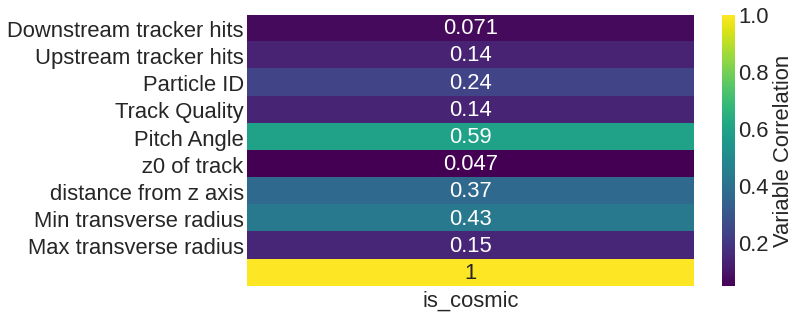

In [ ]:
corr = noCRV.corr();
sns.heatmap(abs(corr), xticklabels=list(map(translation.get, corr.columns.values)), yticklabels=corr.columns.values, cbar_kws={'label': 'Fraction of Events'});
plt.figure();
sns.heatmap(abs(corr[['is_cosmic']]), yticklabels=list(map(translation.get, corr.columns.values)), fmt='.2g', cmap='viridis', annot=True, cbar_kws={'label': 'Variable Correlation'});

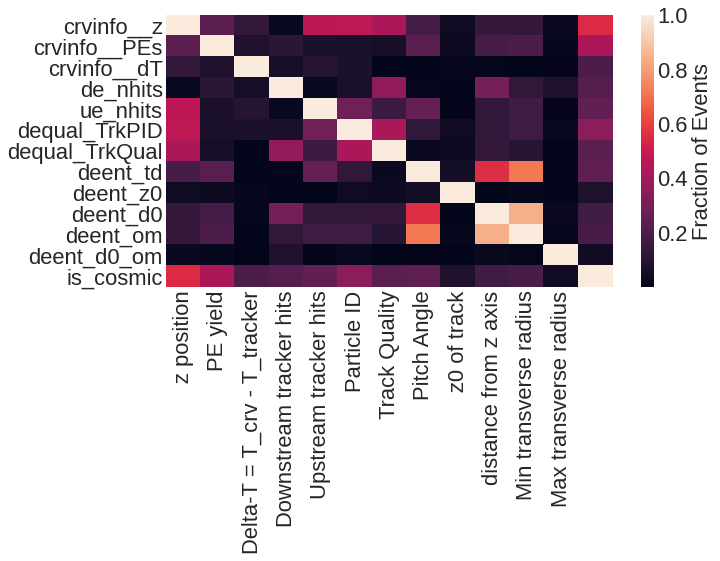

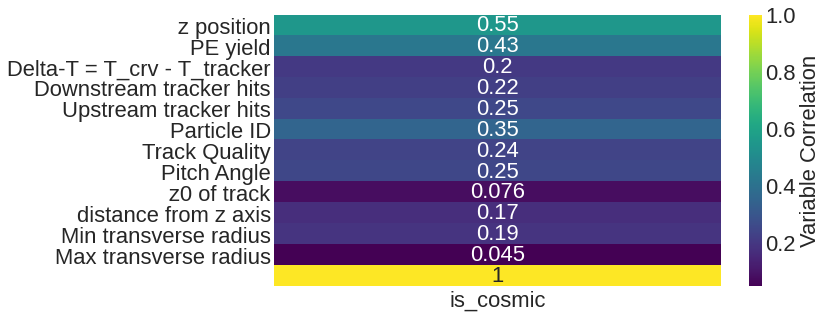

In [ ]:
corr = onlyCRV.corr();
sns.heatmap(abs(corr), xticklabels=list(map(translation.get, corr.columns.values)), yticklabels=corr.columns.values, cbar_kws={'label': 'Fraction of Events'});
plt.figure();
sns.heatmap(abs(corr[['is_cosmic']]), yticklabels=list(map(translation.get, corr.columns.values)), fmt='.2g', cmap='viridis', annot=True, cbar_kws={'label': 'Variable Correlation'});

#Training Model & Varying MetaParameters

In [ ]:
class Dropout(keras.layers.Dropout): #ripped straight from https://indico.cern.ch/event/917074/contributions/3855332/attachments/2035180/3407260/MCDropoutMLCoffee8thMay.pdf
  def __init__(self, rate, training=None, noise_shape=None, seed=None, **kwargs):
    super(Dropout, self).__init__(rate, noise_shape=None, seed=None, **kwargs)
    self.training = training

  def call(self, inputs, training=None):
    if 0. < self.rate < 1.:
      noise_shape = self._get_noise_shape(inputs)

      def dropped_inputs():
        return K.dropout(inputs, self.rate, noise_shape, seed=self.seed)
      
      if not training:
        return K.in_train_phase(dropped_inputs, inputs, training=self.training)
      
      return K.in_train_phase(dropped_inputs, inputs, training=training)
    
    return inputs

In [ ]:
def varyMetaParameters(trainingSet, trainingY, ValidationSet, ValidationY, widthMultiplier = 2, depth = 4, batch = 100):
  keras.backend.clear_session() #This clears the previous training
  width = len(trainingSet[0])
  keras.backend.clear_session()
  model = keras.Sequential()

  model.add(Dense(widthMultiplier*width, input_dim=width, activation='relu'))
  for i in range(depth):
    model.add(Dense(widthMultiplier*width, activation='relu'))
    model.add(Dropout(0.2, training=True))
  model.add(Dense(widthMultiplier*width, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))

  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

  es_callback = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]
  print("fitting model with width=",widthMultiplier,"*",width,"\tdepth=",depth + 1,"\tsize=",1000*batch)
  history = model.fit(x=trainingSet, y=trainingY, epochs=250, batch_size=1000*batch, validation_data=(ValidationSet, ValidationY), verbose=True, callbacks = es_callback);

  return history, model

In [ ]:
allHistory, allModel = varyMetaParameters(X_train, y_train, X_val, y_val, 4, 6, 10)
Allacc = allHistory.history['accuracy'][-1]

CRVHistory, CRVModel = varyMetaParameters(CRV_X_train, CRV_y_train, CRV_X_val, CRV_y_val, 4, 6, 10)
CRVacc = CRVHistory.history['accuracy'][-1]

NoCRVHistory, NoCRVModel = varyMetaParameters(noCRV_X_train, noCRV_y_train, noCRV_X_val, noCRV_y_val, 4, 6, 10)
NoCRVacc = NoCRVHistory.history['accuracy'][-1]

fitting model with width= 4 * 12 	depth= 7 	size= 10000
Epoch 1/250
254/254 [==============================] - 58s 220ms/step - loss: 0.2926 - accuracy: 0.8681 - val_loss: 0.0473 - val_accuracy: 0.9848
Epoch 2/250
254/254 [==============================] - 24s 94ms/step - loss: 0.0437 - accuracy: 0.9859 - val_loss: 0.0382 - val_accuracy: 0.9877
Epoch 3/250
254/254 [==============================] - 24s 93ms/step - loss: 0.0374 - accuracy: 0.9879 - val_loss: 0.0353 - val_accuracy: 0.9886
Epoch 4/250
254/254 [==============================] - 24s 93ms/step - loss: 0.0347 - accuracy: 0.9888 - val_loss: 0.0344 - val_accuracy: 0.9886
Epoch 5/250
254/254 [==============================] - 23s 91ms/step - loss: 0.0334 - accuracy: 0.9892 - val_loss: 0.0327 - val_accuracy: 0.9894
Epoch 6/250
254/254 [==============================] - 23s 92ms/step - loss: 0.0322 - accuracy: 0.9895 - val_loss: 0.0329 - val_accuracy: 0.9892
Epoch 7/250
254/254 [==============================] - 23s 90ms/step - lo

#Analysing Best Model Found

In [ ]:
# print("Best Model Summary")
# bestmodel.summary()
# for l in bestmodel.layers:
#     print(l.name, l.input_shape[1],'==>',l.output_shape[1])
# print("\noverall accuracy:",bestAccuracy)

In [ ]:
# def draw_neural_net(ax, left, right, bottom, top, layer_sizes):
#     '''
#     Draw a neural network cartoon using matplotilb.
    
#     :usage:
#         >>> fig = plt.figure(figsize=(12, 12))
#         >>> draw_neural_net(fig.gca(), .1, .9, .1, .9, [4, 7, 2])
    
#     :parameters:
#         - ax : matplotlib.axes.AxesSubplot
#             The axes on which to plot the cartoon (get e.g. by plt.gca())
#         - left : float
#             The center of the leftmost node(s) will be placed here
#         - right : float
#             The center of the rightmost node(s) will be placed here
#         - bottom : float
#             The center of the bottommost node(s) will be placed here
#         - top : float
#             The center of the topmost node(s) will be placed here
#         - layer_sizes : list of int
#             List of layer sizes, including input and output dimensionality
#     '''
#     n_layers = len(layer_sizes)
#     v_spacing = (top - bottom)/(max(layer_sizes))
#     h_spacing = (right - left)/(len(layer_sizes) - 1)
#     # Nodes
#     for n, layer_size in enumerate(layer_sizes):
#         layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
#         for m in range(layer_size):
#             circle = plt.Circle((n*h_spacing + left, layer_top - m*v_spacing), v_spacing/4.,
#                                 color='w', ec='k', zorder=4)
#             ax.add_artist(circle)
#     # Edges
#     for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
#         layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
#         layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
#         for m in range(layer_size_a):
#             for o in range(layer_size_b):
#                 line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
#                                   [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], c='k')
#                 ax.add_artist(line)

In [ ]:
# fig = plt.figure(figsize=(10, 10))
# plt.axis('off')
# layers=[12]+[15]+[15]+[1]
# draw_neural_net(fig.gca(), .1, .9, .1, .9, layers)

In [ ]:
def plotAcc(history, modelType):
  fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(14,5))

  ax1.plot(history.history['accuracy'], label="training")
  ax1.plot(history.history['val_accuracy'], label="validation")
  ax1.set_title('model accuracy - ' + modelType)
  ax1.set_ylabel('accuracy')
  ax1.set_xlabel('epoch')
  ax1.legend(loc='bottom right')
  ax1.set_ylim(0.99,1)
  # ax1.set_yscale('log');

  ax2.plot(history.history['loss'], 'r-', label="training")
  ax2.plot(history.history['val_loss'], 'g-', label="validation")
  ax2.set_title('model loss - ' + modelType)
  ax2.set_ylabel('loss')
  ax2.set_xlabel('epoch')
  ax2.legend(loc='best')
  ax2.set_ylim(0,0.1);
  # ax2.set_yscale('log');
  plt.tight_layout()
  plt.show()

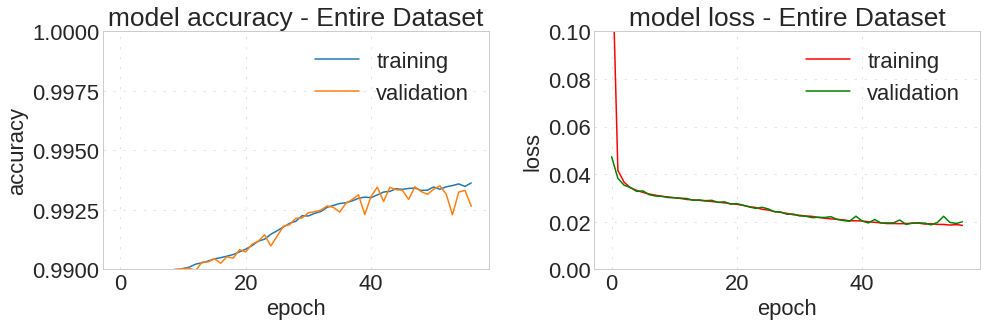

In [ ]:
plotAcc(allHistory, "Entire Dataset")

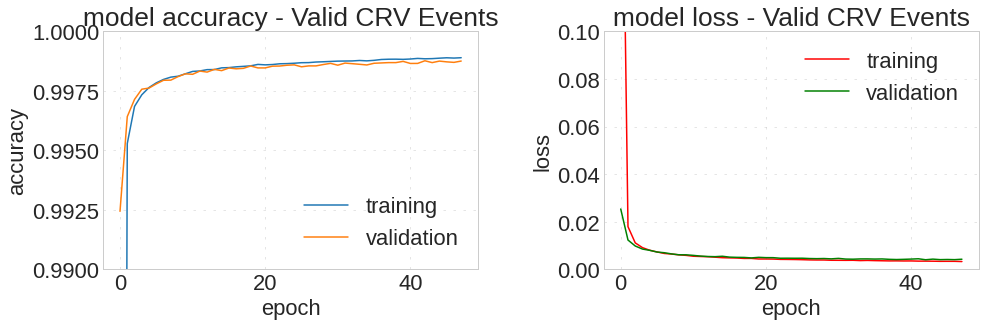

In [ ]:
plotAcc(CRVHistory, "Valid CRV Events")

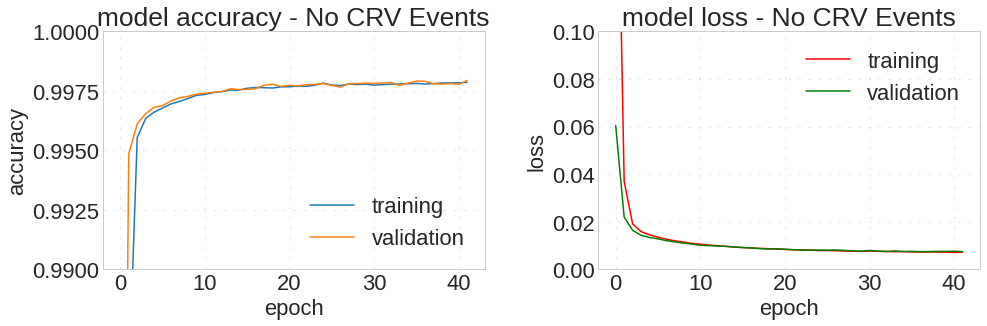

In [ ]:
plotAcc(NoCRVHistory, "No CRV Events")

In [ ]:
# watcher = ww.WeightWatcher(model=bestmodel);
# details = watcher.analyze(randomize=True, plot=True);

In [ ]:
# summary = watcher.get_summary(details);

In [ ]:
# summary

In [ ]:
# details

In [ ]:
# plt.plot(details['alpha'])

#Predictions using MC Dropout

In [ ]:
def predict_with_MC_error(model, test_data, num_iter = 10):
  predictions_list = []
  for i in range(num_iter):
    predictions_list.append(model.predict(test_data, verbose=1).reshape(-1))
    print("iteration", i + 1, "done")
  predictions = np.mean(predictions_list, axis=0).reshape(-1)

  return predictions_list, predictions

In [ ]:
all_preds, predictions = predict_with_MC_error(allModel, X_test, num_iter=30)

26425/26425 [==============================] - 33s 1ms/step
iteration 1 done
26425/26425 [==============================] - 31s 1ms/step
iteration 2 done
26425/26425 [==============================] - 31s 1ms/step
iteration 3 done
26425/26425 [==============================] - 31s 1ms/step
iteration 4 done
26425/26425 [==============================] - 32s 1ms/step
iteration 5 done
26425/26425 [==============================] - 32s 1ms/step
iteration 6 done
26425/26425 [==============================] - 32s 1ms/step
iteration 7 done
26425/26425 [==============================] - 31s 1ms/step
iteration 8 done
26425/26425 [==============================] - 31s 1ms/step
iteration 9 done
26425/26425 [==============================] - 32s 1ms/step
iteration 10 done
26425/26425 [==============================] - 31s 1ms/step
iteration 11 done
26425/26425 [==============================] - 31s 1ms/step
iteration 12 done
26425/26425 [==============================] - 31s 1ms/step
iteration 13 

In [ ]:
NoCRV_all_preds, NoCRV_predictions = predict_with_MC_error(NoCRVModel, no_CRV_X_test, num_iter=30)

10595/10595 [==============================] - 13s 1ms/step
iteration 1 done
10595/10595 [==============================] - 12s 1ms/step
iteration 2 done
10595/10595 [==============================] - 12s 1ms/step
iteration 3 done
10595/10595 [==============================] - 12s 1ms/step
iteration 4 done
10595/10595 [==============================] - 12s 1ms/step
iteration 5 done
10595/10595 [==============================] - 12s 1ms/step
iteration 6 done
10595/10595 [==============================] - 12s 1ms/step
iteration 7 done
10595/10595 [==============================] - 12s 1ms/step
iteration 8 done
10595/10595 [==============================] - 12s 1ms/step
iteration 9 done
10595/10595 [==============================] - 12s 1ms/step
iteration 10 done
10595/10595 [==============================] - 12s 1ms/step
iteration 11 done
10595/10595 [==============================] - 12s 1ms/step
iteration 12 done
10595/10595 [==============================] - 12s 1ms/step
iteration 13 

In [ ]:
CRV_all_preds, CRV_predictions = predict_with_MC_error(CRVModel, CRV_X_test, num_iter=30)

15831/15831 [==============================] - 19s 1ms/step
iteration 1 done
15831/15831 [==============================] - 19s 1ms/step
iteration 2 done
15831/15831 [==============================] - 19s 1ms/step
iteration 3 done
15831/15831 [==============================] - 19s 1ms/step
iteration 4 done
15831/15831 [==============================] - 19s 1ms/step
iteration 5 done
15831/15831 [==============================] - 19s 1ms/step
iteration 6 done
15831/15831 [==============================] - 19s 1ms/step
iteration 7 done
15831/15831 [==============================] - 19s 1ms/step
iteration 8 done
15831/15831 [==============================] - 19s 1ms/step
iteration 9 done
15831/15831 [==============================] - 19s 1ms/step
iteration 10 done
15831/15831 [==============================] - 19s 1ms/step
iteration 11 done
15831/15831 [==============================] - 19s 1ms/step
iteration 12 done
15831/15831 [==============================] - 18s 1ms/step
iteration 13 

#Analytics of MC Dropout Results

In [ ]:
print("Brier Score of:", 1 - brier_score_loss(y_test, predictions), "for all data")
print("Brier Score of:", 1 - brier_score_loss(CRV_y_test, CRV_predictions), "for just CRV data")
print("Brier Score of:", 1 - brier_score_loss(no_CRV_y_test, NoCRV_predictions), "for no CRV data")

Brier Score of: 0.99537897416359 for all data
Brier Score of: 0.9991811213877755 for just CRV data
Brier Score of: 0.9984057237974069 for no CRV data


In [ ]:
def produceMatrix(divider):
  rounded = np.where(predictions < divider, 0, 1)
  confusion = confusion_matrix(y_test, rounded, normalize=None);
  sns.heatmap(confusion, annot=True, xticklabels=["noise", "cosmic"], yticklabels=["noise", "cosmic"], fmt='.5g');
  plt.xlabel("Predicted Label");
  plt.ylabel("True Label");
  return confusion, rounded

In [ ]:
def confusionmatrix(eff, percentage, cutoff):
  plt.figure(figsize=(10,7))
  
  annotStr = annot=np.array([[str(round(eff[0][0])) + '\n(' + str(round(percentage[0][0],5)) + ')', str(round(eff[0][1])) + '\n(' + str(round(percentage[0][1],5)) + ')'], [str(round(eff[1][0])) + '\n(' + str(round(percentage[1][0],5)) + ')', str(round(eff[1][1])) + '\n(' + str(round(percentage[1][1],5)) + ')']])

  ax = sns.heatmap(percentage, annot=annotStr, xticklabels=["CE + Noise", "cosmic"], yticklabels=["CE + Noise", "cosmic"], fmt='.18s', cbar_kws={'label': 'Fraction of Events'});
  
  ax.set(title="Confusion Matrix with Cutoff at " + str(round(cutoff, 5)),
        xlabel="Predicted Label",
        ylabel="True Label",);
    

In [ ]:
def outputHisto(prediction, ytest, cutoff):
  fig, ax = plt.subplots(1,2, figsize=(30,7))


  ax[0].hist(prediction[ytest==1], range=(-0.1,1.1), bins=1000, histtype='step', label='Cosmics');
  ax[0].hist(prediction[ytest==0], range=(-0.1,1.1), bins=1000, histtype='step', label='CE & Noise');
  ax[0].axvline(cutoff, label="Cutoff = " + str(round(cutoff, 5)), color='black')
  ax[0].set_yscale('log');
  ax[0].legend(loc='upper center');

  fpr_keras, tpr_keras, thresholds_keras = roc_curve(ytest, prediction);
  auc_keras = auc(fpr_keras, tpr_keras);
  ax[1].plot([0, 1], [0, 1], 'k--');
  ax[1].plot(fpr_keras, tpr_keras, label='Keras test data(area = {:.5f})'.format(auc_keras));
  ax[1].set_xlabel('False positive rate');
  ax[1].set_ylabel('True positive rate');
  ax[1].set_title('ROC curve');
  ax[1].set_ylim(0.999,1.001);
  # ax[1].set_yscale('log');
  ax[1].legend();

  ax[0].set_title("Values Returned for Cosmics and CE/Noise");
  ax[0].set_xlabel("Value Returned");
  ax[0].set_ylabel("Frequency");

In [ ]:
def cutoffTime(ytest, prediction):
  rejectionList = []
  ceList = []

  def cutoffScanner(ytest, prediction, upper, lower): #Defined within function so that global variable can be used
    divider = (upper + lower)/2
    rounded = np.where(prediction < divider, 0, 1)
    confusion = confusion_matrix(ytest, rounded, normalize='true');
    rejectionList.append((divider, confusion[1][1]))
    ceList.append((divider, confusion[0][0]))
    # print("Done with divider of:", divider,"==>", round(confusion[1][1], 6))

    if divider < 0.0001 and round(confusion[1][1], 6) != 1:
      print("Mission failed, we'll get em next time. Closest cutoff found of: ", divider)
      return divider, confusion_matrix(ytest, rounded), rounded, confusion

    elif (round(confusion[1][1],5) == 0.99994):
      # print("Cutoff found of: ", divider)
      return divider, confusion_matrix(ytest, rounded), rounded, confusion

    elif round(confusion[1][1],5) > 0.99994:
      return cutoffScanner(ytest, prediction, upper, divider)

    else:
      return cutoffScanner(ytest, prediction, divider, lower)

  cutoff, effs, rounded_predictions, percentages = cutoffScanner(ytest, prediction, 1, 0)
  fig, ax = plt.subplots(2,1, figsize=(8,12), sharex=True)
  rejectionList = sorted(rejectionList)
  ceList = sorted(ceList)
  ax[0].plot(*zip(*rejectionList), label="Cosmic", color='blue', marker='o');
  ax[1].plot(*zip(*ceList), label="CE", color='orange', marker='o');
  if cutoff < 0.01:
    plt.xscale('log');
  ax[0].set_ylabel('Efficiency');
  ax[1].set_ylabel('Efficiency');
  ax[0].set_title('Cosmic');
  ax[1].set_title('CE & Noise');
  fig.suptitle("Efficiency of Successful Identification VS Cutoff Value", y=1.01);
  fig.text(0.45,0,"Cutoff Value");
  confusionmatrix(effs, percentages, cutoff)
  outputHisto(prediction, ytest, cutoff)
  plt.tight_layout();
  plt.show();
  return cutoff, effs, rounded_predictions, percentages

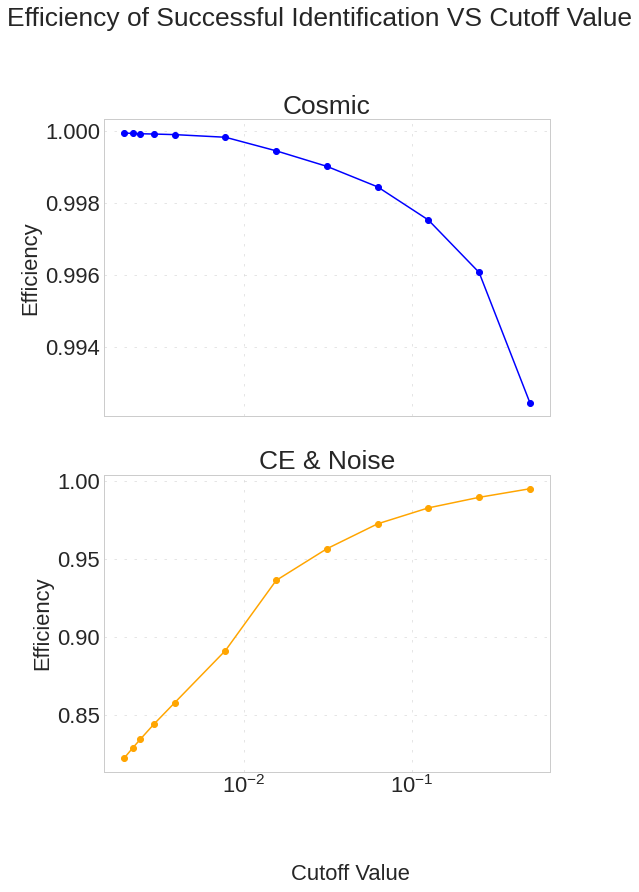

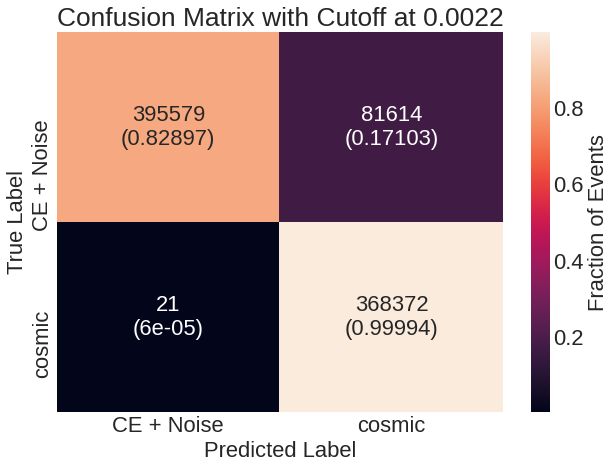

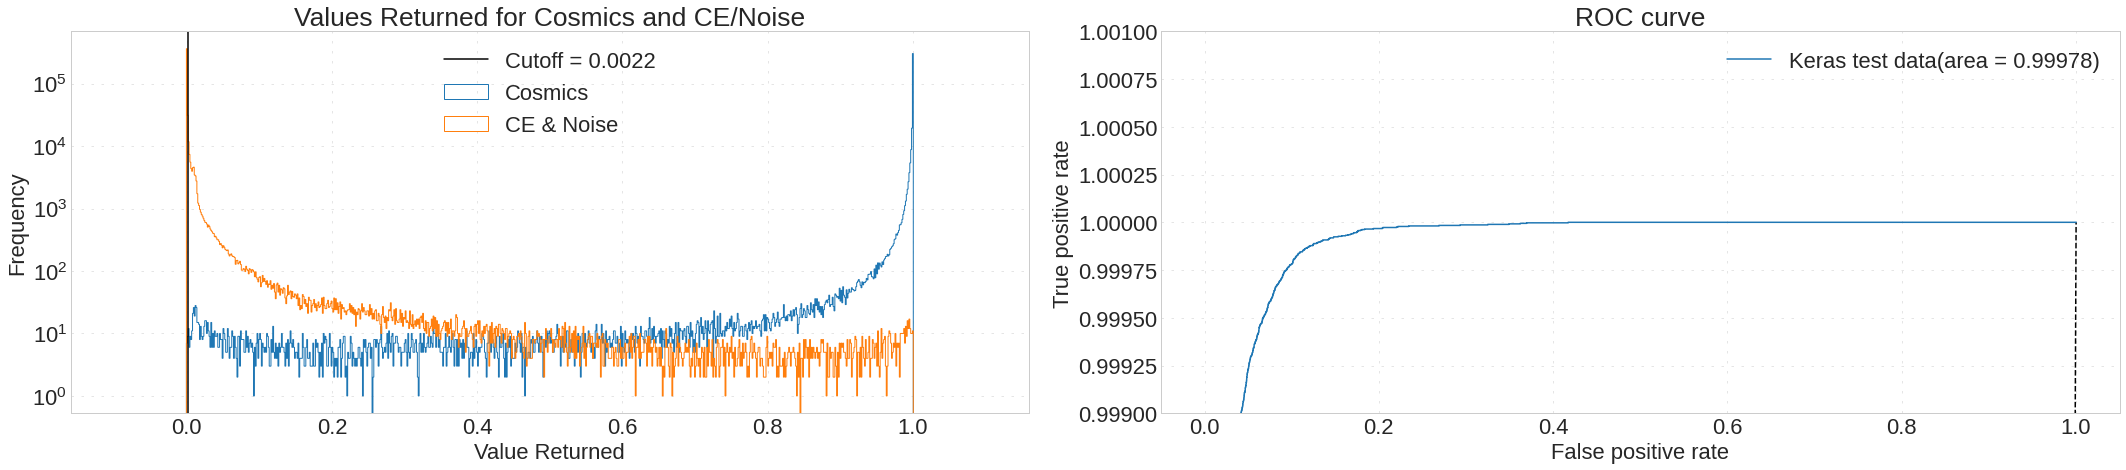

In [ ]:
all_cutoff, all_effs, all_rounded_predictions, all_percentages = cutoffTime(y_test, predictions)

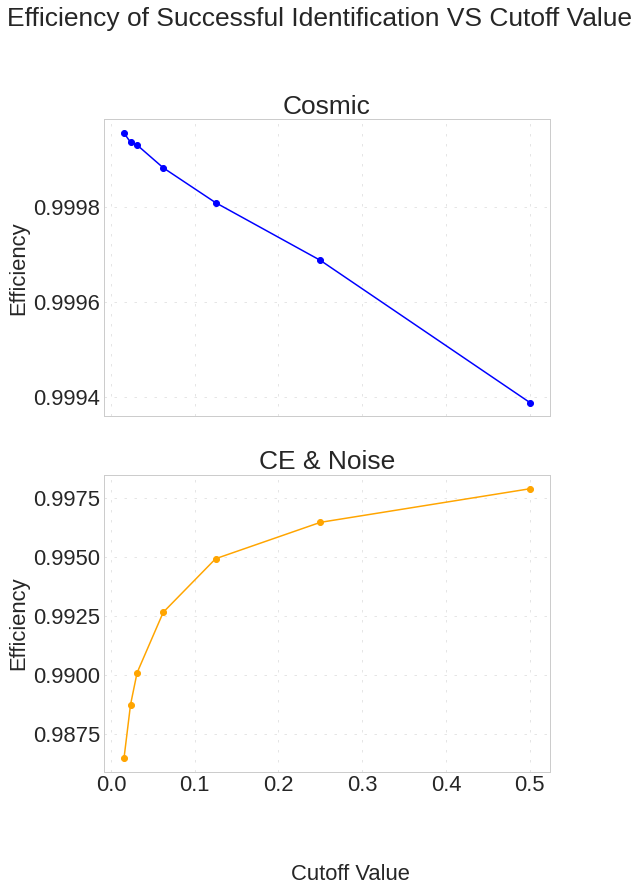

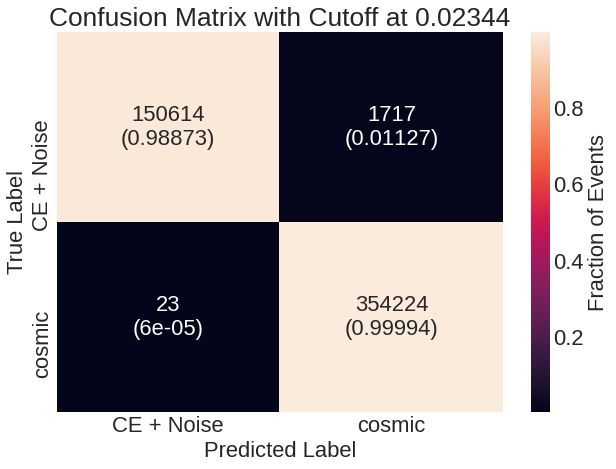

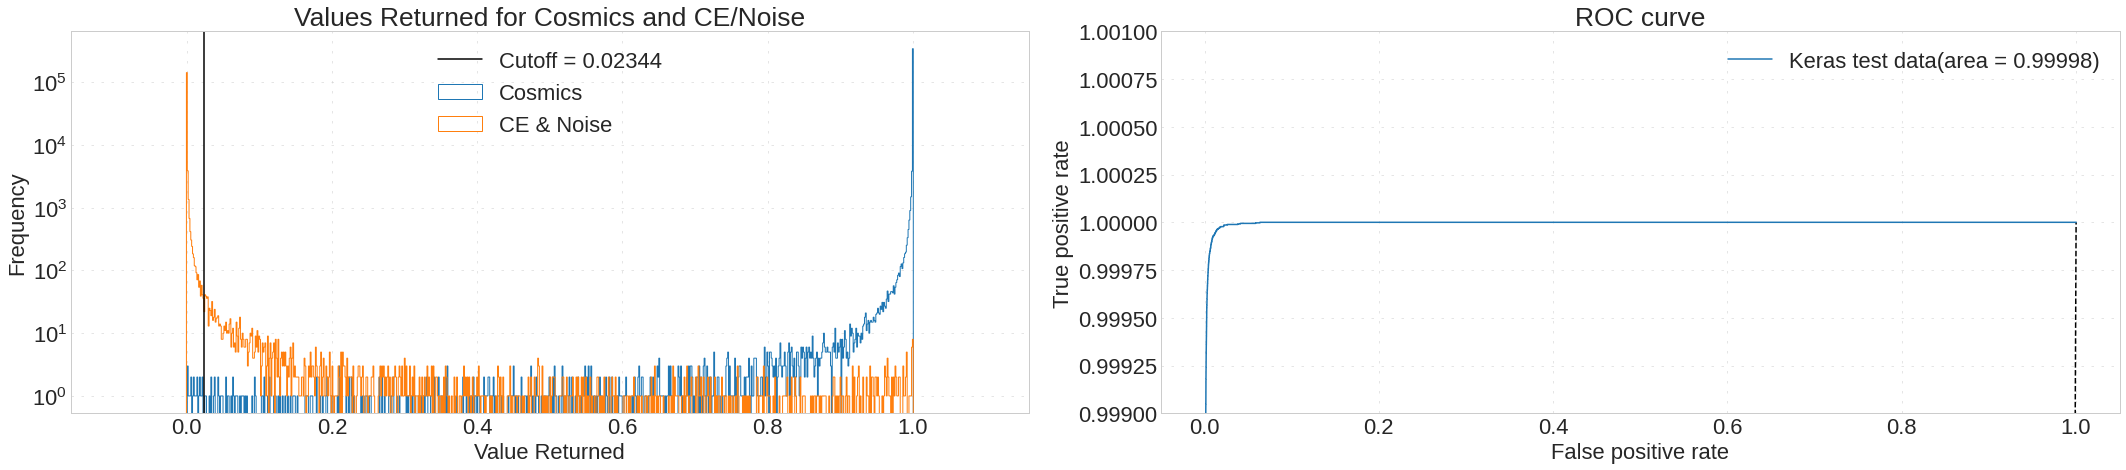

In [ ]:
CRVcutoff, CRVeffs, CRVrounded_predictions, CRVpercentages = cutoffTime(CRV_y_test, CRV_predictions)

Mission failed, we'll get em next time. Closest cutoff found of:  6.103515625e-05


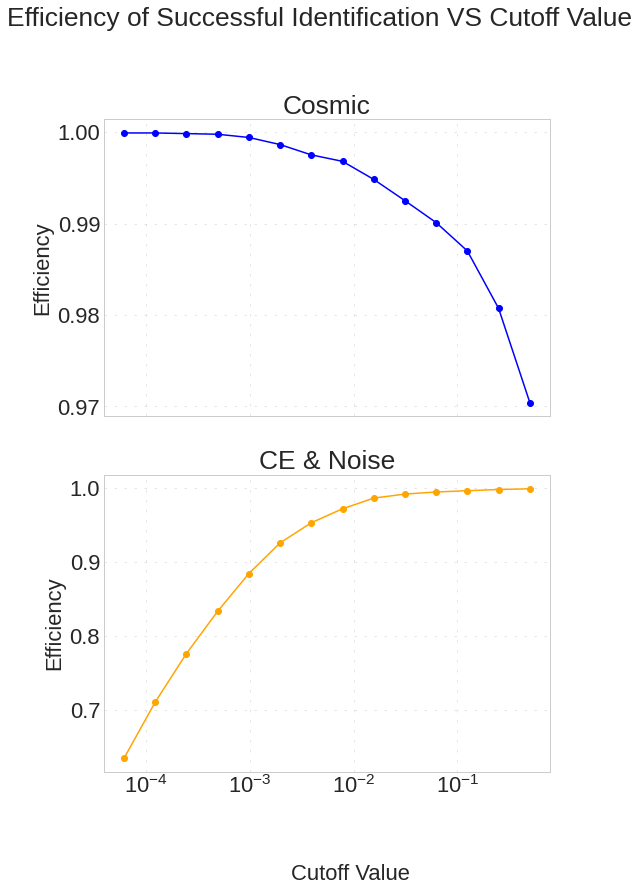

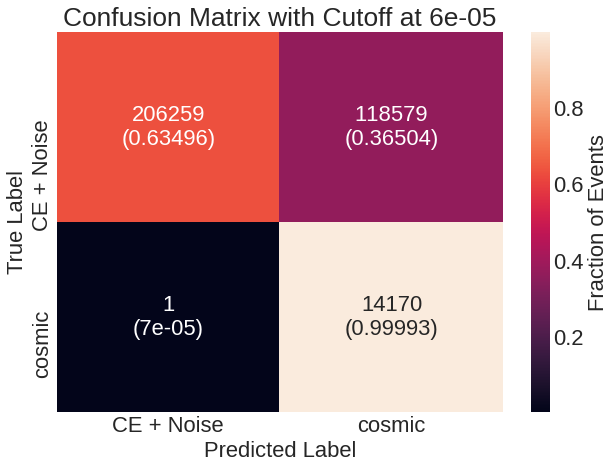

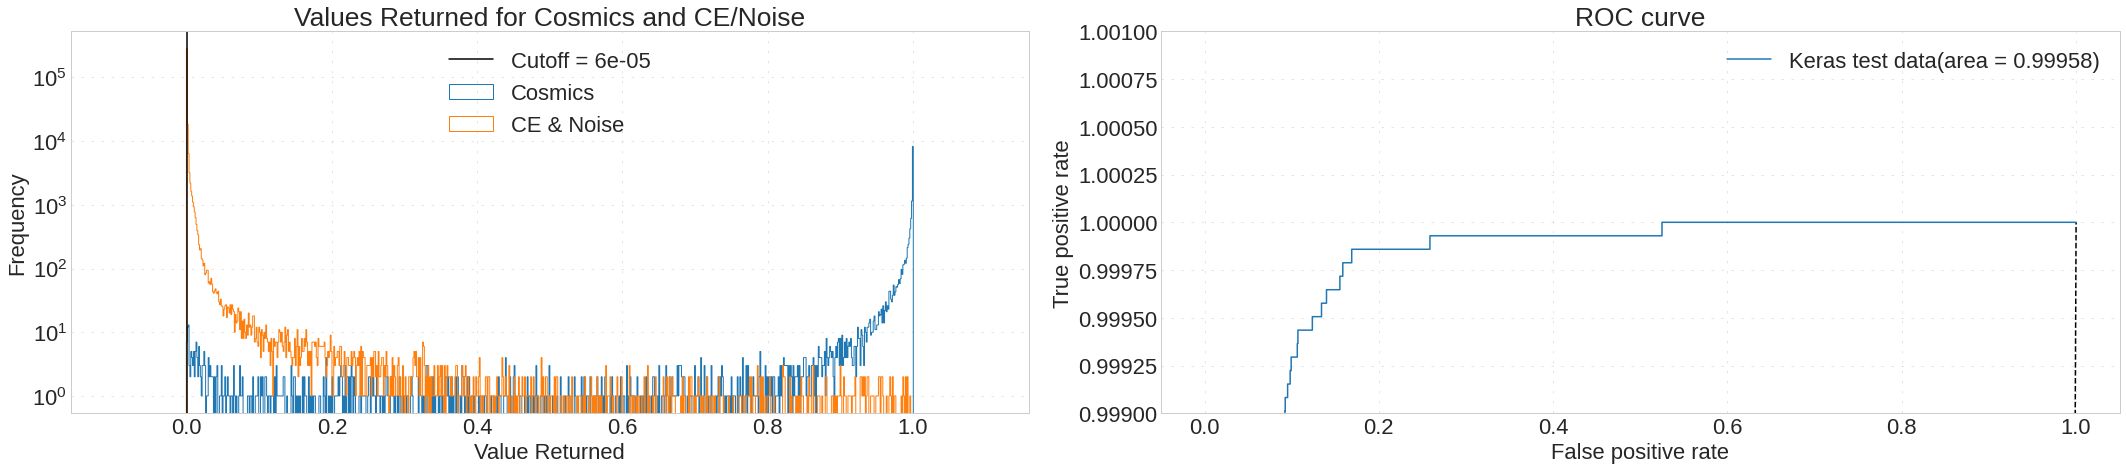

In [ ]:
NoCRVcutoff, NoCRVeffs, NoCRVrounded_predictions, NoCRVpercentages = cutoffTime(no_CRV_y_test, NoCRV_predictions)

In [ ]:
# ncos = np.count_nonzero(y_test ==1)
# nCE = np.count_nonzero(y_test ==0)
# print("Number of cosmics:", ncos)
# print("Number Correctly Identified as Cosmics:", round(effs[1][1]), "(" + str(effs[1][1]/ncos) + ")", "<-- ANALOGUE FOR CUT VETO EFFICIENCY")
# print("Number of CEs Identified as Cosmics:", round(effs[0][1]), "(" + str(effs[0][1]/nCE) + ")")
# print()
# print("Number of CEs:", nCE)
# print("Number Correctly Identified as CEs:", round(nCE), "(" + str(effs[0][0]/nCE) + ")", "<-- ANALOGUE FOR CUT CE RECONSTRUCTION EFFICIENCY")
# print("Number of cosmics Identified as CEs:", round(effs[1][0]), "(" + str(effs[1][0]/ncos) + ")")

In [ ]:
def ErrorCalculations(X_test_df2, all_predictions, out, ytest, variables_list):
  X_test_df2 = X_test_df2.to_numpy()
  AbsoluteErrors = np.var(all_predictions, axis=0) #Gets the error for each event (the error is the variance in accordance with the paper linked earlier from CERN)

  TPErrors = {} #True positive
  FPErrors = {} #False positive
  FNErrors = {} #False negative
  TNErrors = {} #True negative

  TPInputs = [] #True positive
  FPInputs = [] #False positive
  FNInputs = [] #False negative
  TNInputs = [] #True negative

  for i in range(len(out)): #Placing everything in its respective bucket
    if (out[i] == 1) and (ytest[i] == 1):
      TPErrors[i] = AbsoluteErrors[i]
      TPInputs.append(X_test_df2[i])
    elif out[i] == 1 and ytest[i] == 0:
      FPErrors[i] = AbsoluteErrors[i]
      FPInputs.append(X_test_df2[i])
    elif out[i] == 0 and ytest[i] == 1:
      FNErrors[i] = AbsoluteErrors[i]
      FNInputs.append(X_test_df2[i])
    elif out[i] == 0 and ytest[i] == 0:
      TNErrors[i] = AbsoluteErrors[i]
      TNInputs.append( X_test_df2[i])

  def couldaMadeADifference(predictions, errorDict, categoryValue):
    count = 0
    for i in errorDict:
      if abs(predictions[i] - cutoff) < errorDict[i]:
        count += 1 #The uncertainty could have made a difference in the classification here
    return count #Which then returns the number of times that this algorithm could have made a difference in the classification
  
  categoryUncertainties = np.ceil(np.array([ [max(couldaMadeADifference(predictions, TNErrors, effs[0][0]), np.var(list(TNErrors.values()))*effs[0][0]), max(couldaMadeADifference(predictions, FPErrors, effs[1][0]), np.var(list(FPErrors.values()))*effs[1][0])],
                          [max(couldaMadeADifference(predictions, FNErrors, effs[0][1]), np.var(list(FNErrors.values()))*effs[0][1]), max(couldaMadeADifference(predictions, TPErrors, effs[1][1]), np.var(list(TPErrors.values()))*effs[1][1])] ]))
  nbins = 50
  upper_bound = max(max(TPErrors.values()), max(FPErrors.values()), max(TNErrors.values()), max(FNErrors.values()))
  plt.figure();
  plt.hist(TPErrors.values(), histtype='step', label="True Cosmics", bins=nbins, density = True, range=(0,upper_bound));
  plt.hist(FPErrors.values(), histtype='step', label="CE Labelled as Cosmic", bins=nbins, density = True, range=(0,upper_bound));
  plt.hist(TNErrors.values(), histtype='step', label="True CE", bins=nbins, density = True, range=(0,upper_bound));
  plt.hist(FNErrors.values(), histtype='step', label="Cosmic Labelled as CE", bins=nbins, density = True, range=(0,upper_bound));
  plt.legend(bbox_to_anchor=(1,1), loc="upper left", borderaxespad=0);
  plt.xlabel("Error")
  plt.title("Error Distributions for Different Event Classifications")
  plt.yscale('log');

  TPInputs = pd.DataFrame(np.array(TPInputs), columns=list(variables_list.keys()))
  FPInputs = pd.DataFrame(np.array(FPInputs), columns=list(variables_list.keys()))
  FNInputs = pd.DataFrame(np.array(FNInputs), columns=list(variables_list.keys()))
  TNInputs = pd.DataFrame(np.array(TNInputs), columns=list(variables_list.keys()))

  for var in variables_list:
    try:
      plt.figure(figsize=(20, 10))
      plt.hist(TPInputs[var], histtype='step', label="True Cosmics", bins=nbins, density=True,  range=variables_list[var]);
      plt.hist(FPInputs[var], histtype='step', label="Cosmic Labelled as CE/noise", bins=nbins, density=True,  range=variables_list[var]);
      plt.hist(FNInputs[var], histtype='step', label="CE/noise labelled as Cosmic", bins=nbins, density=True,  range=variables_list[var]);
      plt.hist(TNInputs[var], histtype='step', label="True CE/noise", bins=nbins, density=True,  range=variables_list[var]);
      plt.xlabel(translation[var])
      plt.yscale('log')
      plt.ylabel('Normalized Frequancy')
      plt.legend(prop={'size': 20})
    except:
      continue
  return categoryUncertainties

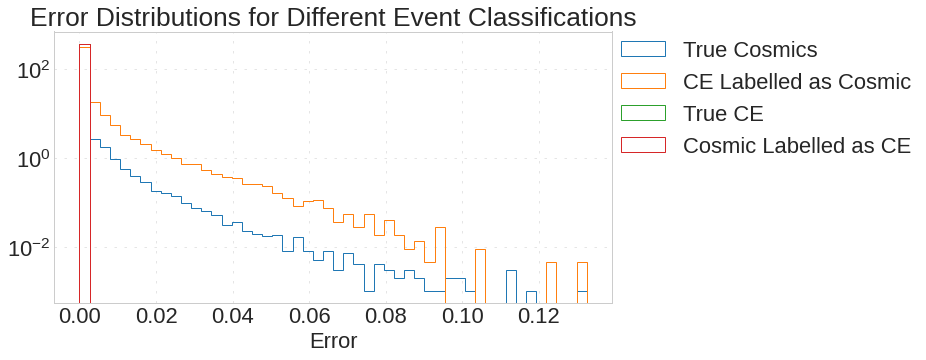

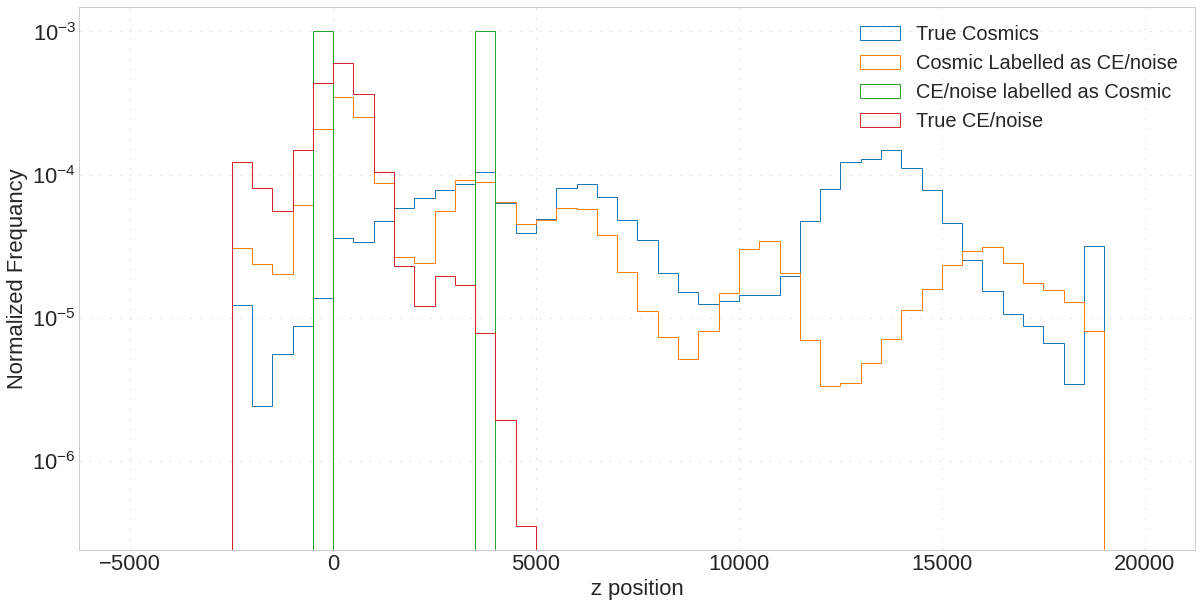

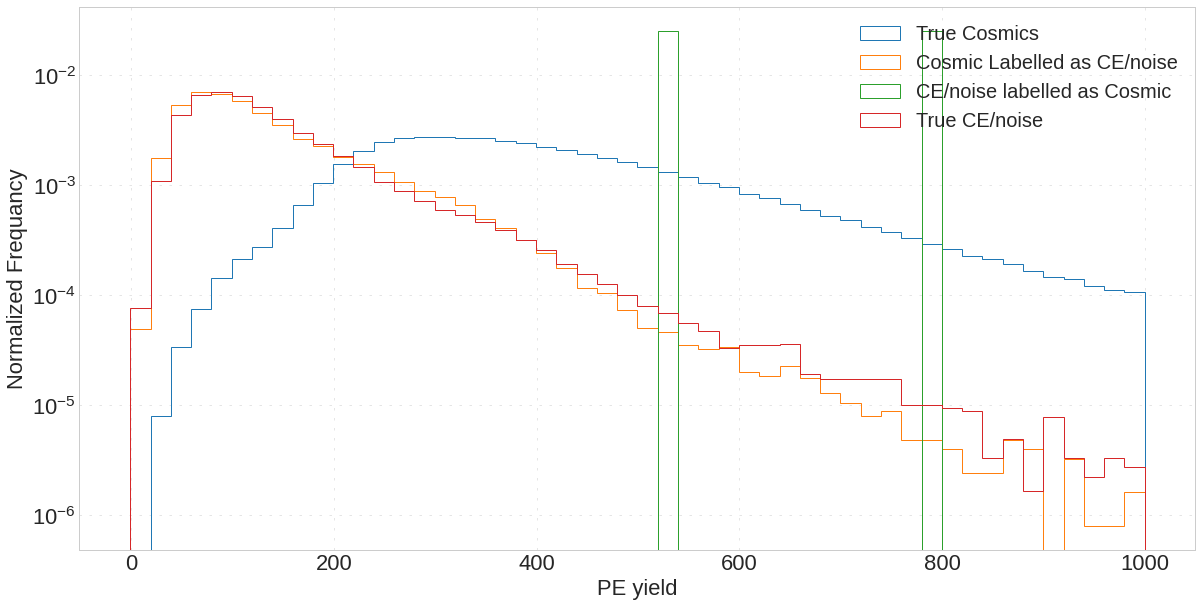

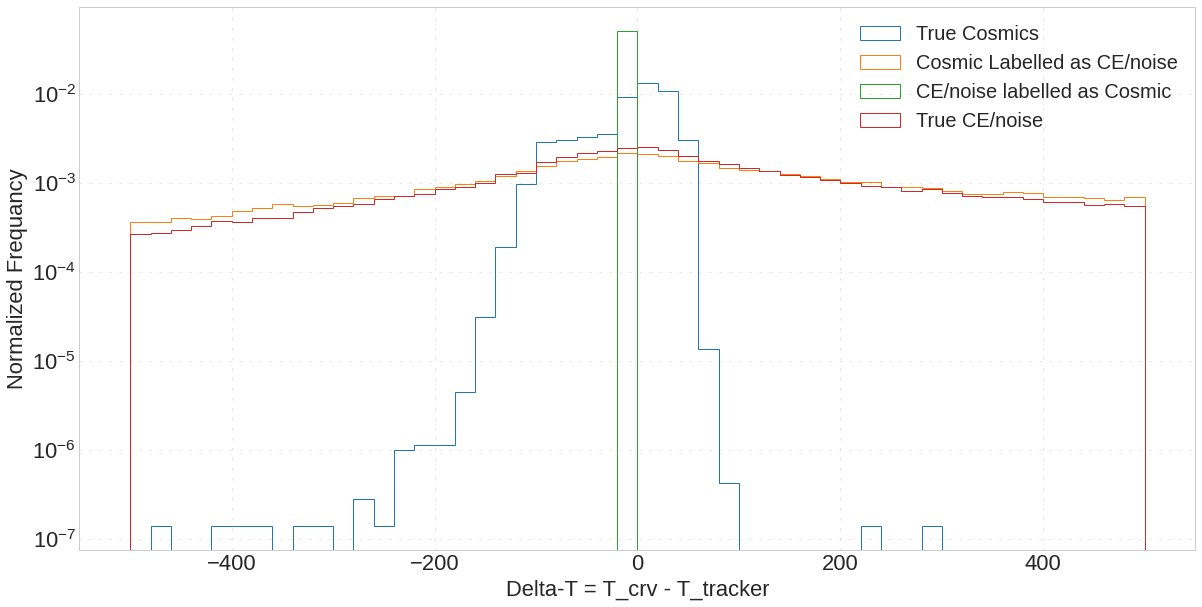

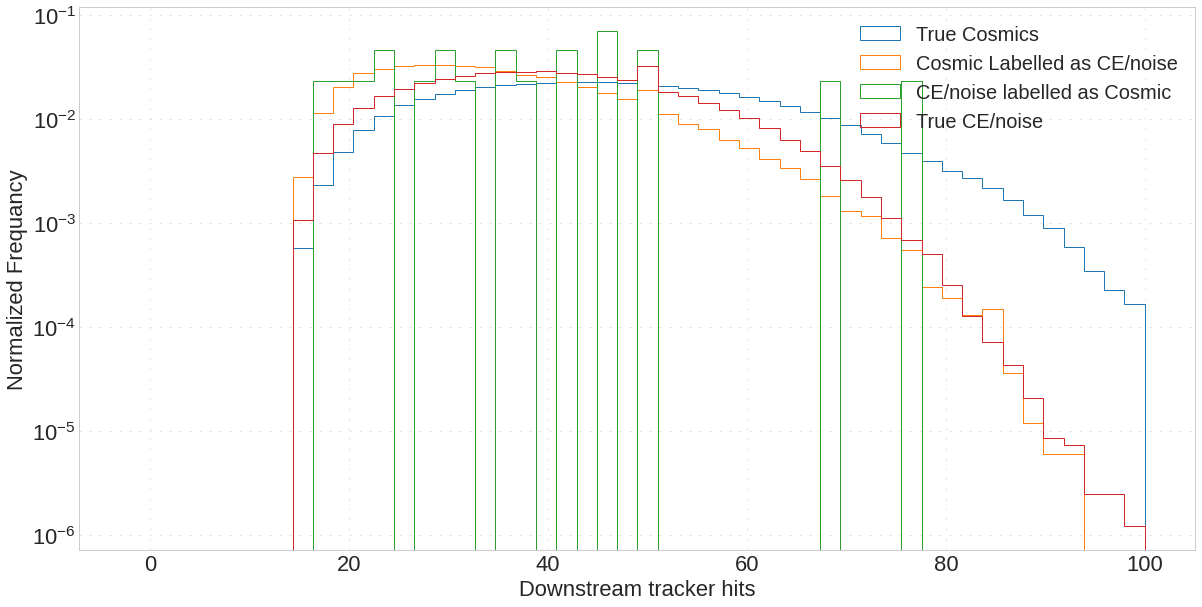

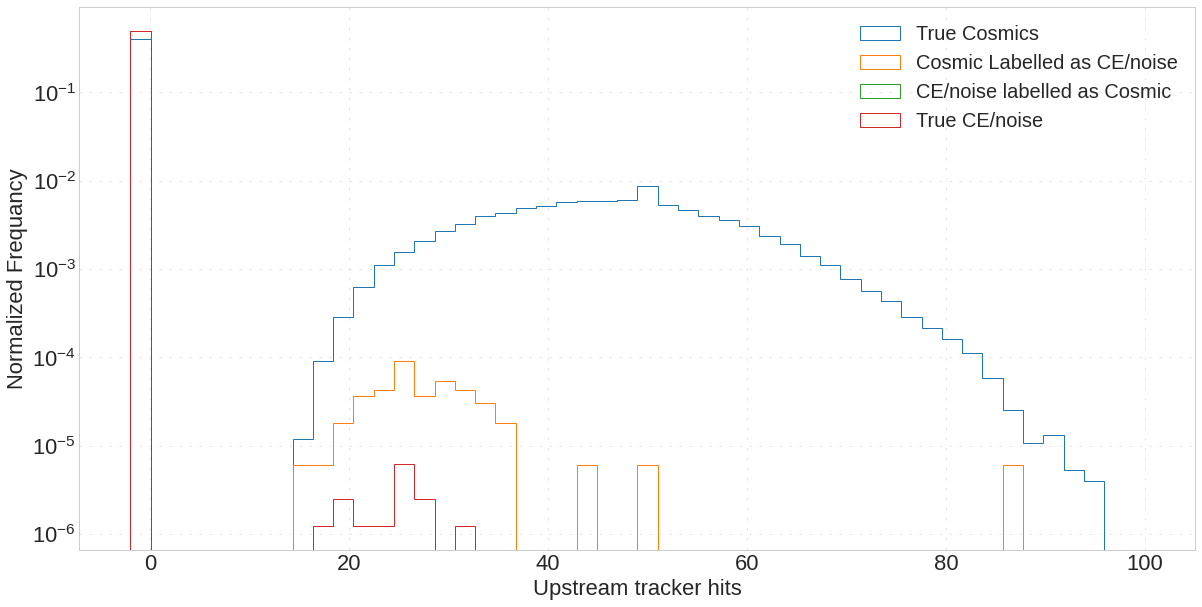

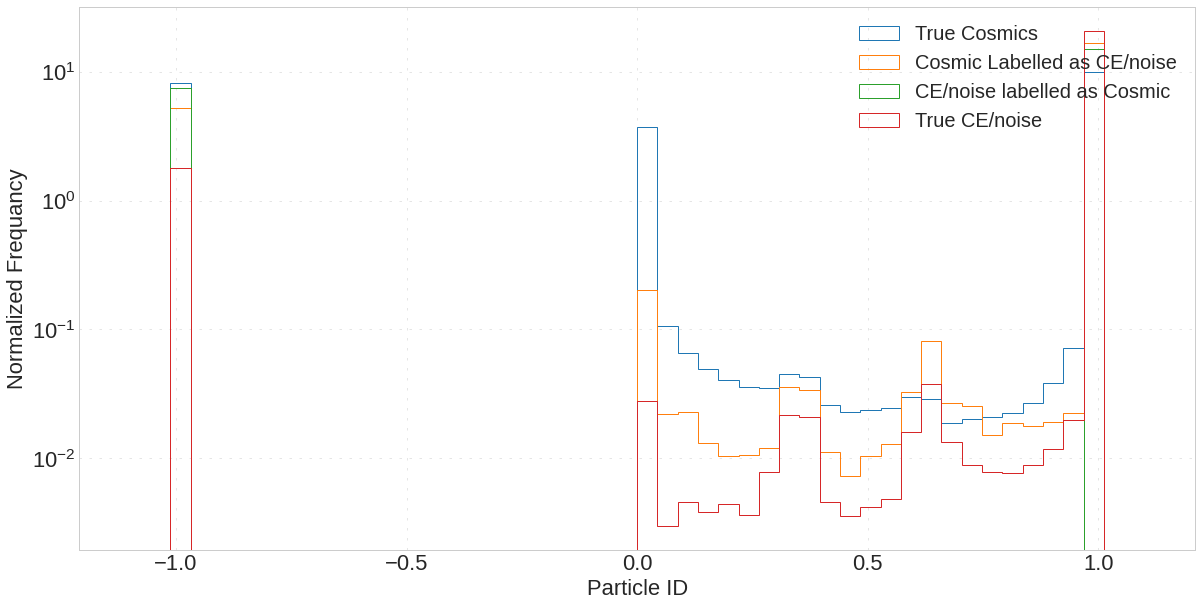

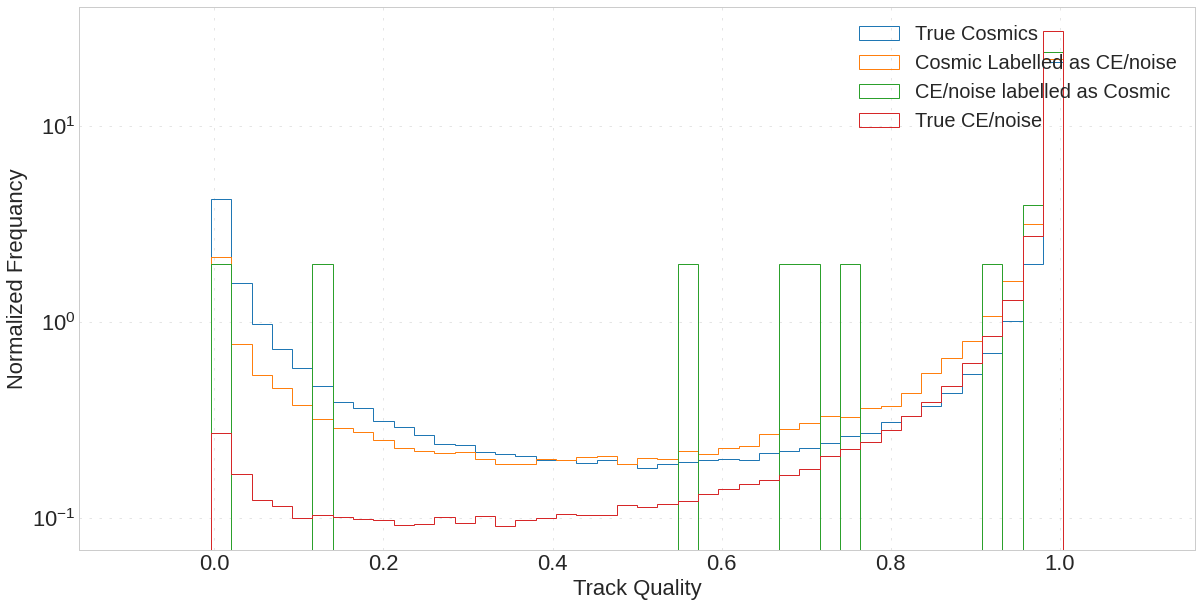

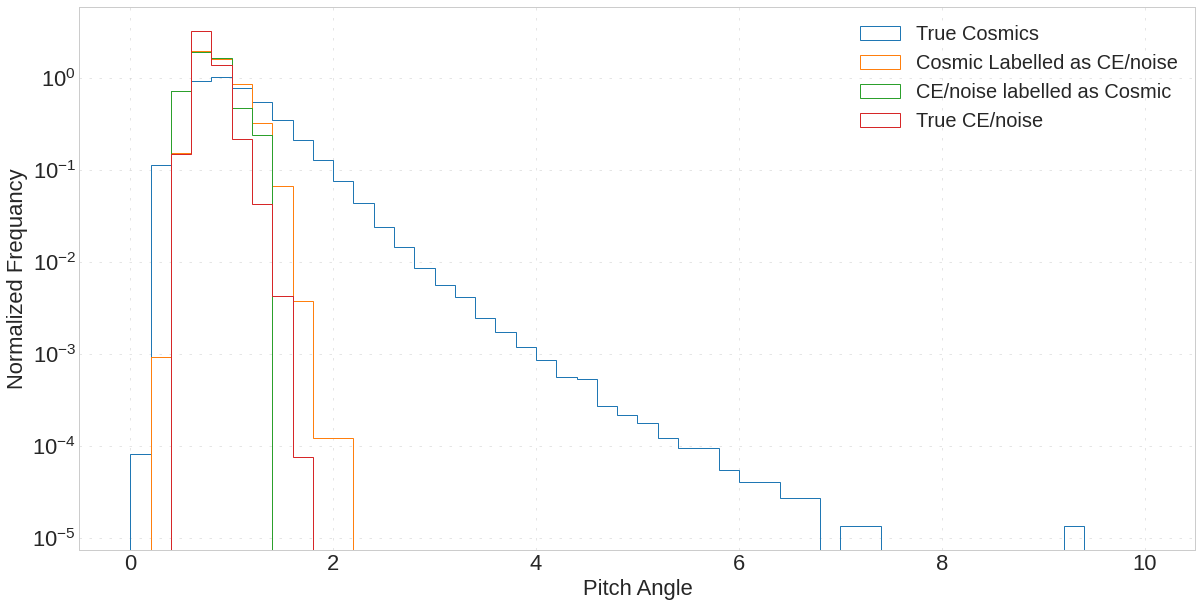

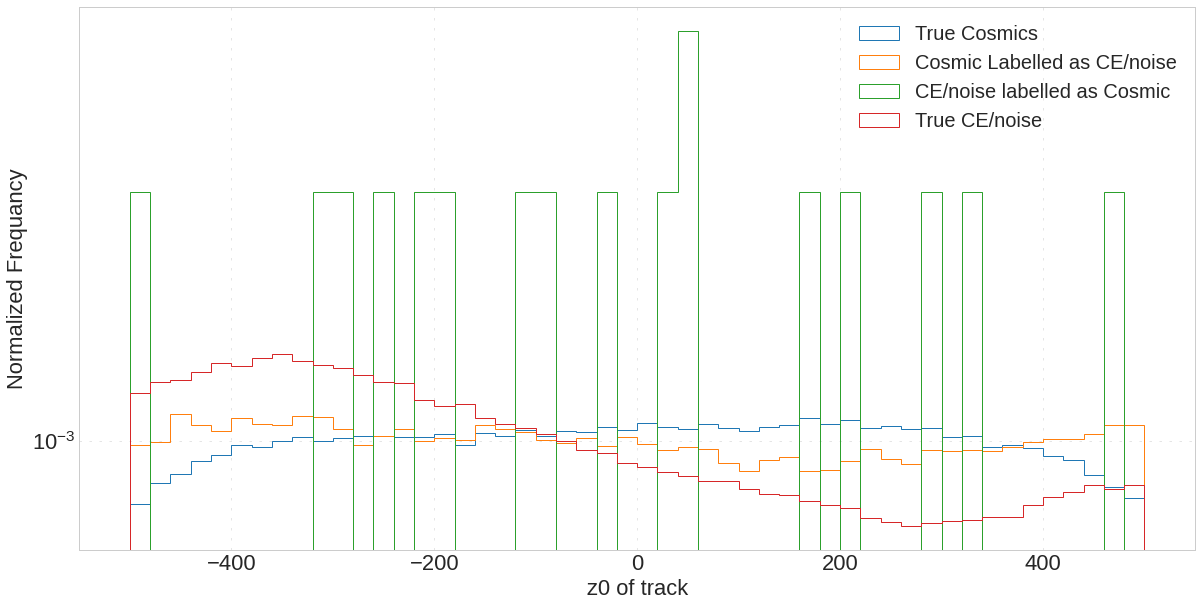

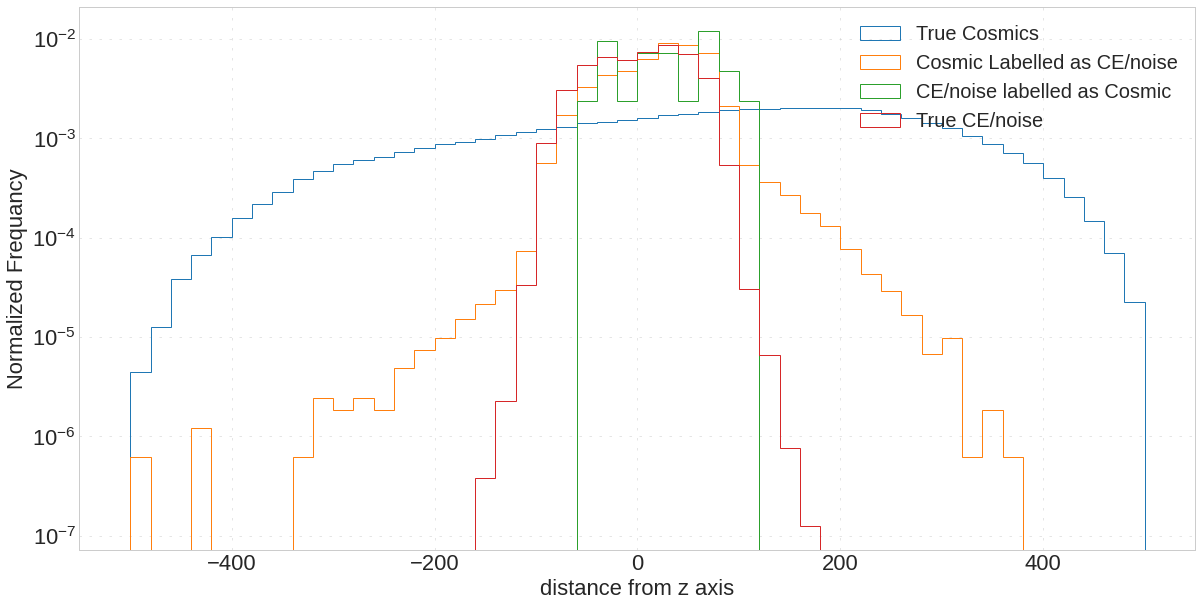

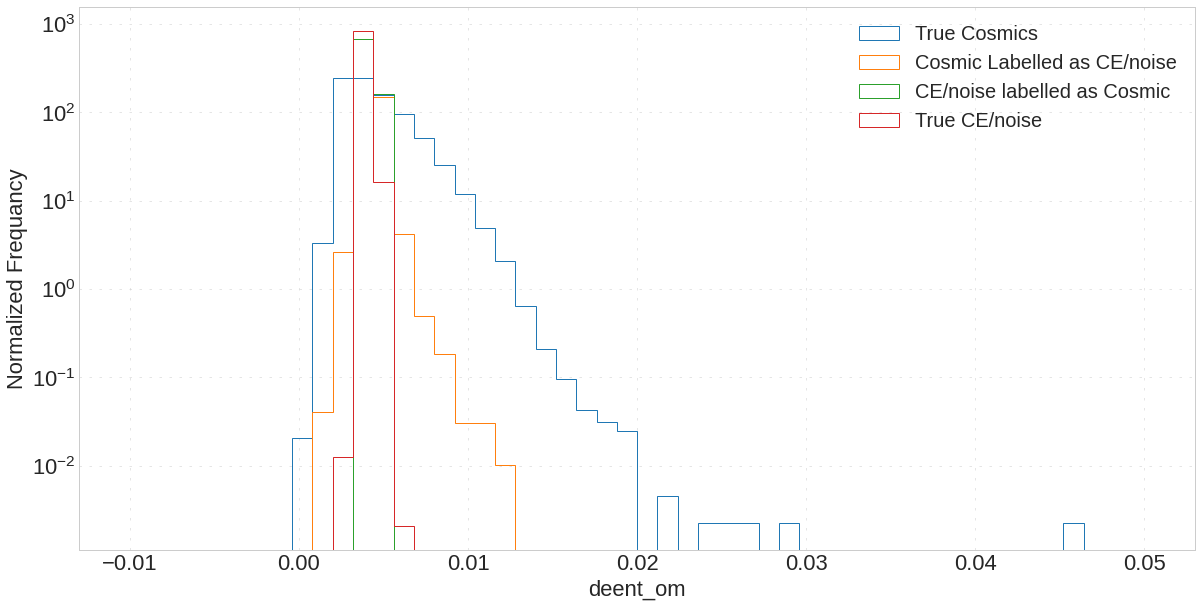

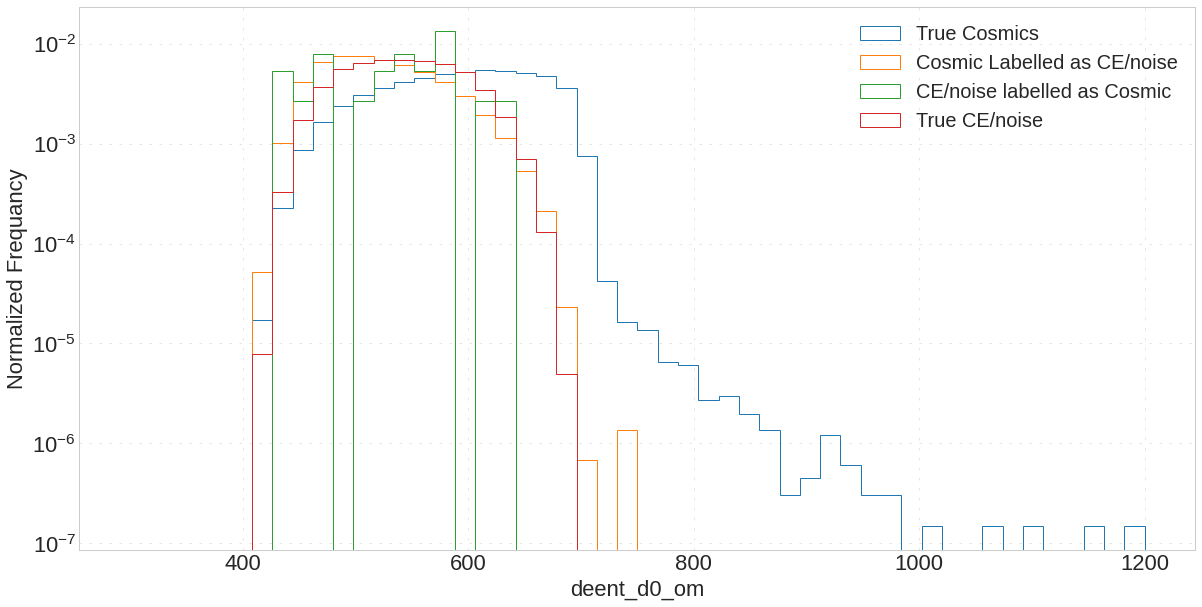

In [ ]:
allErrors = ErrorCalculations(X_test_df, all_preds, all_rounded_predictions, y_test, dTZPE_noMom_variables_list)

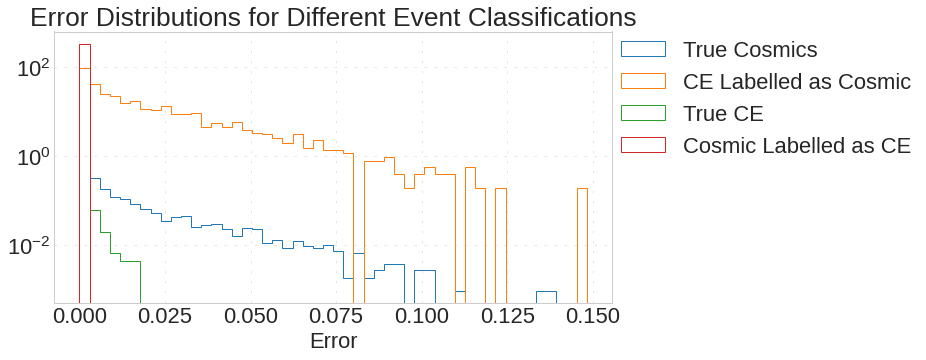

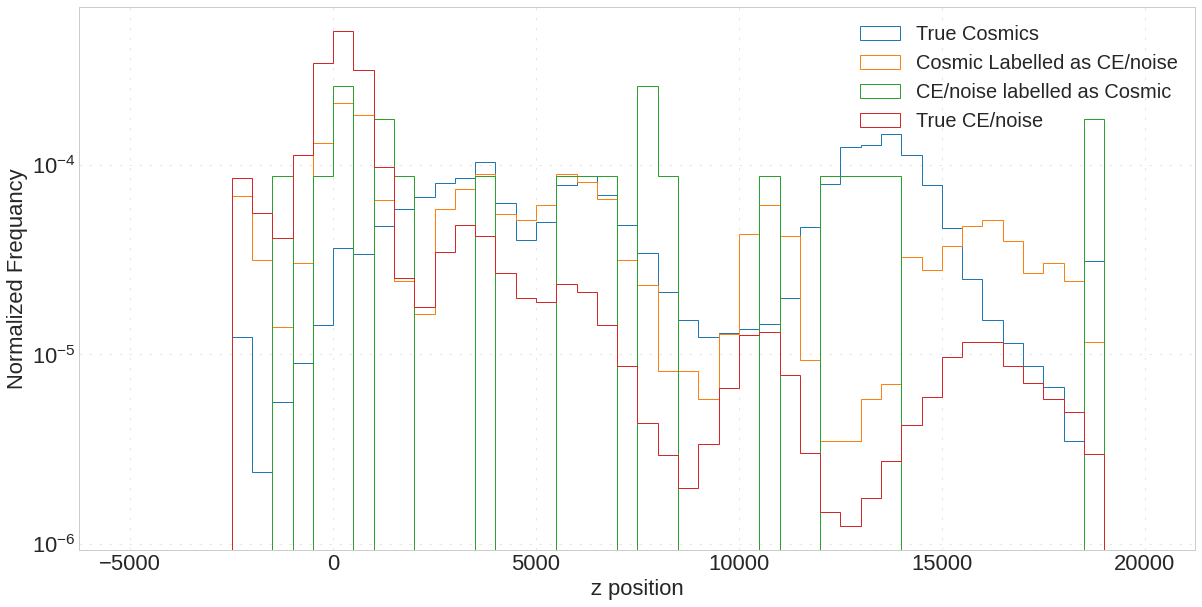

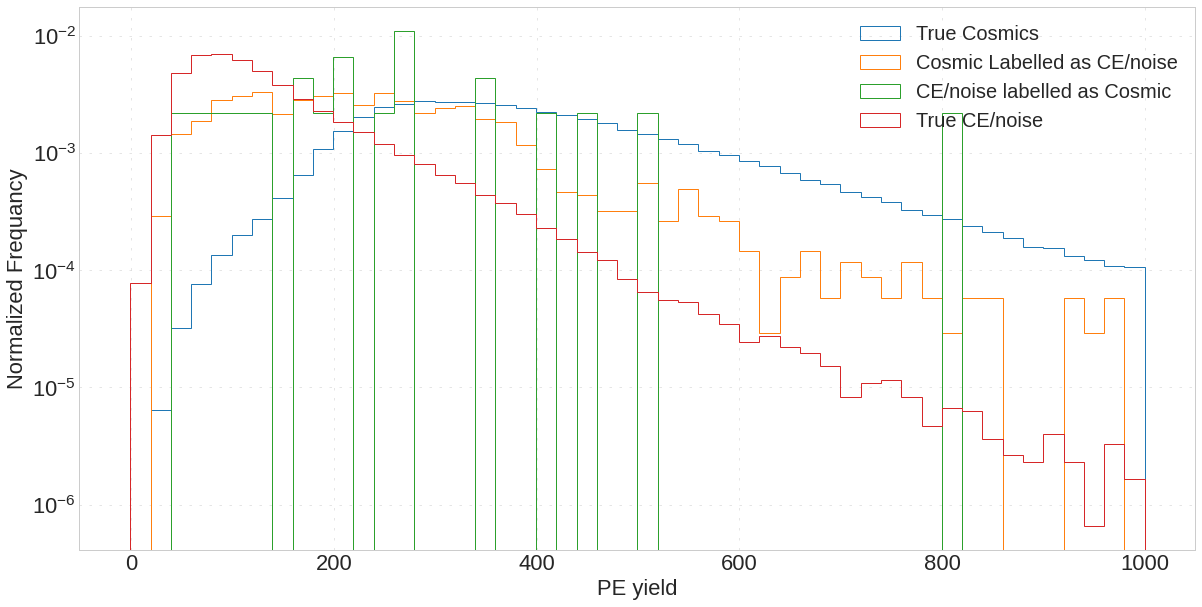

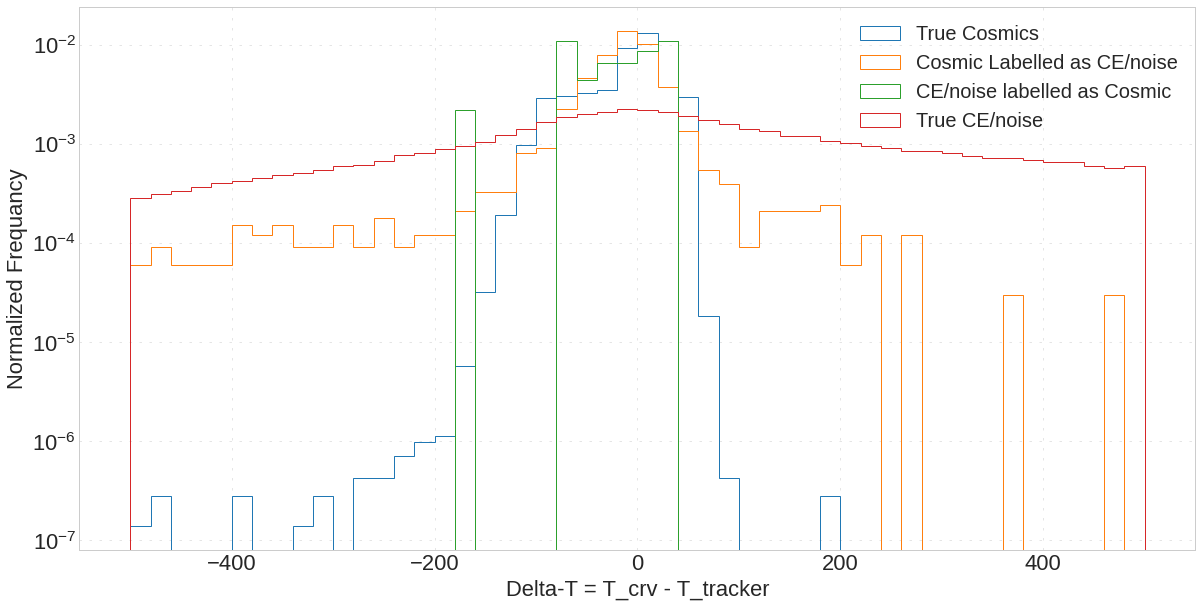

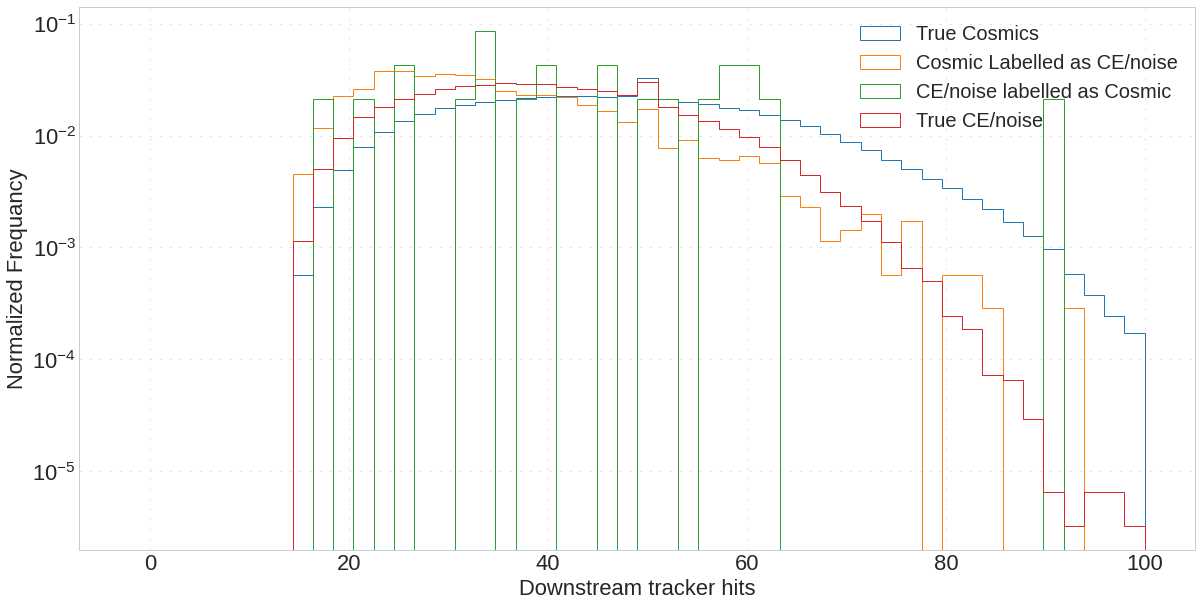

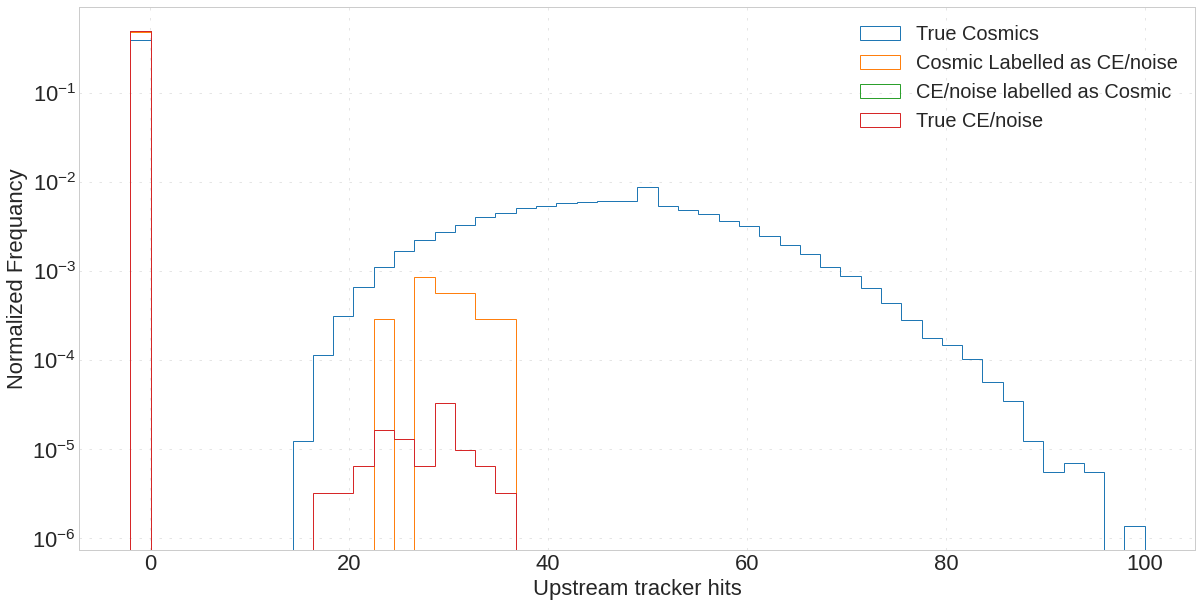

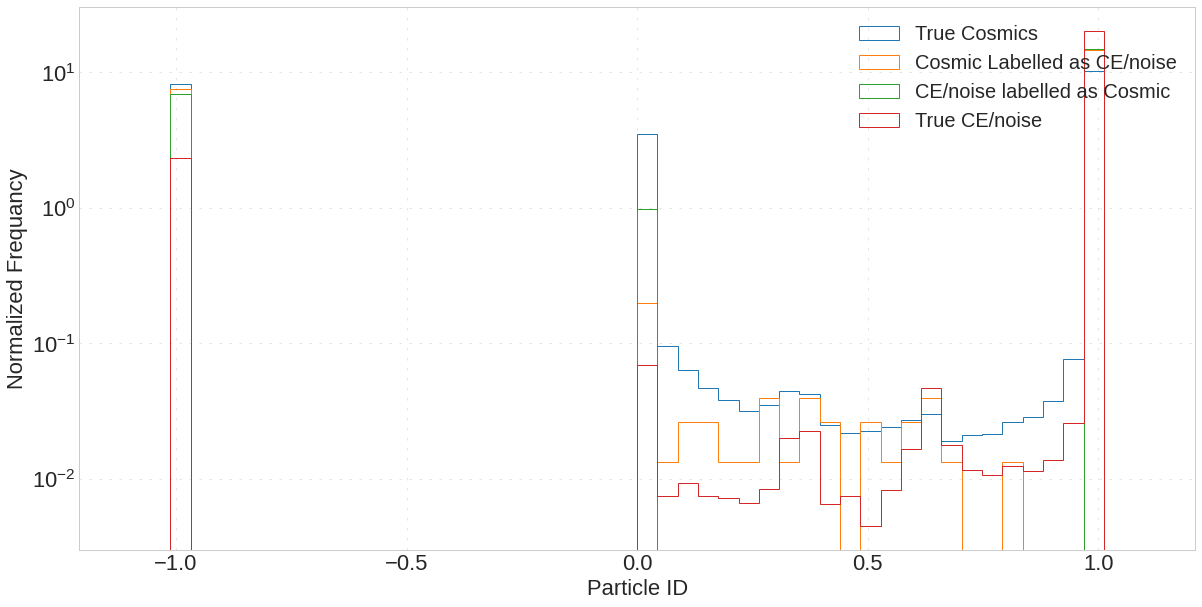

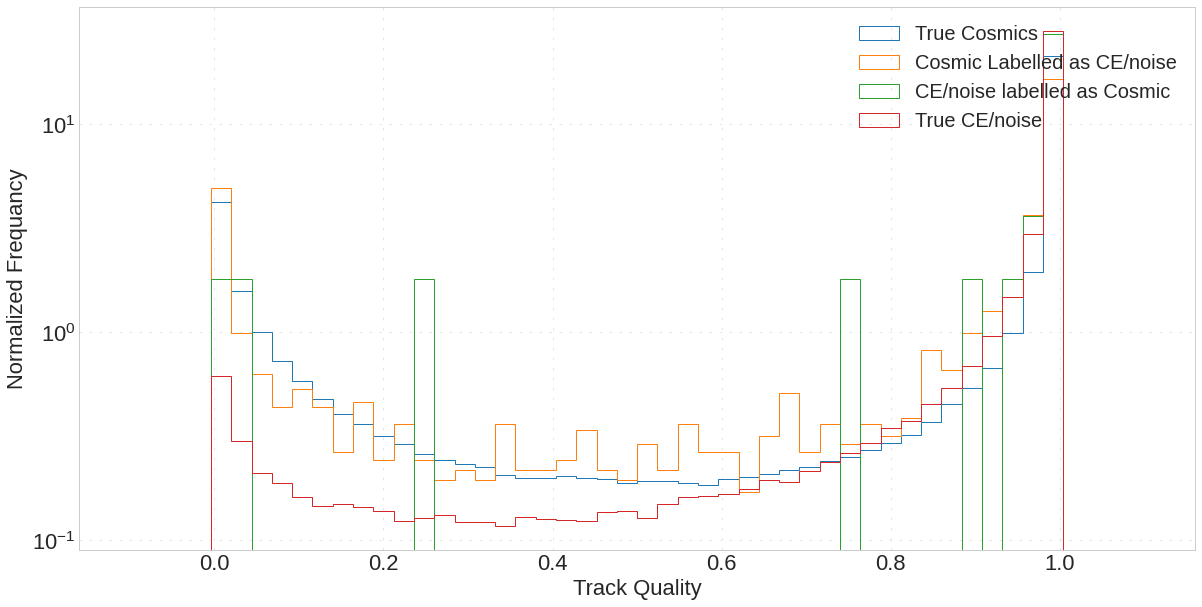

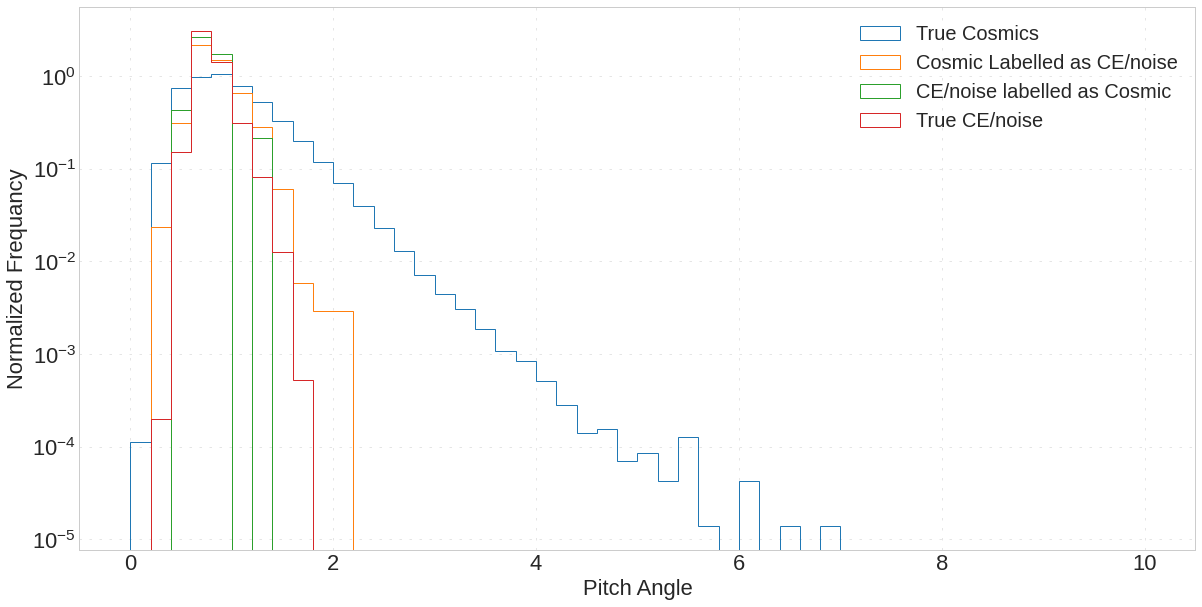

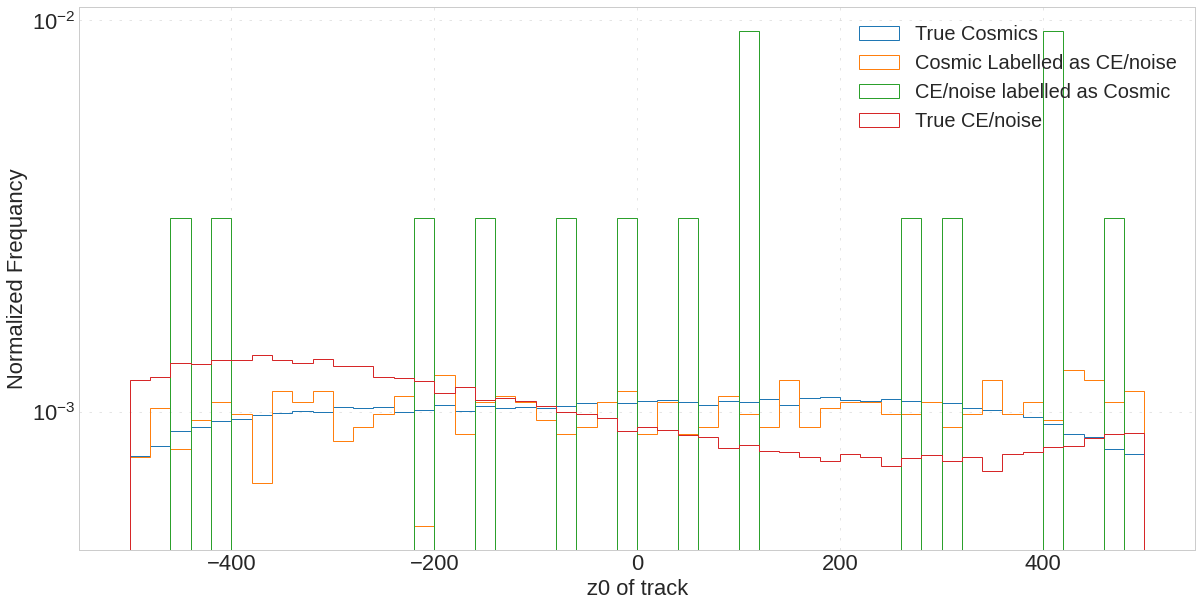

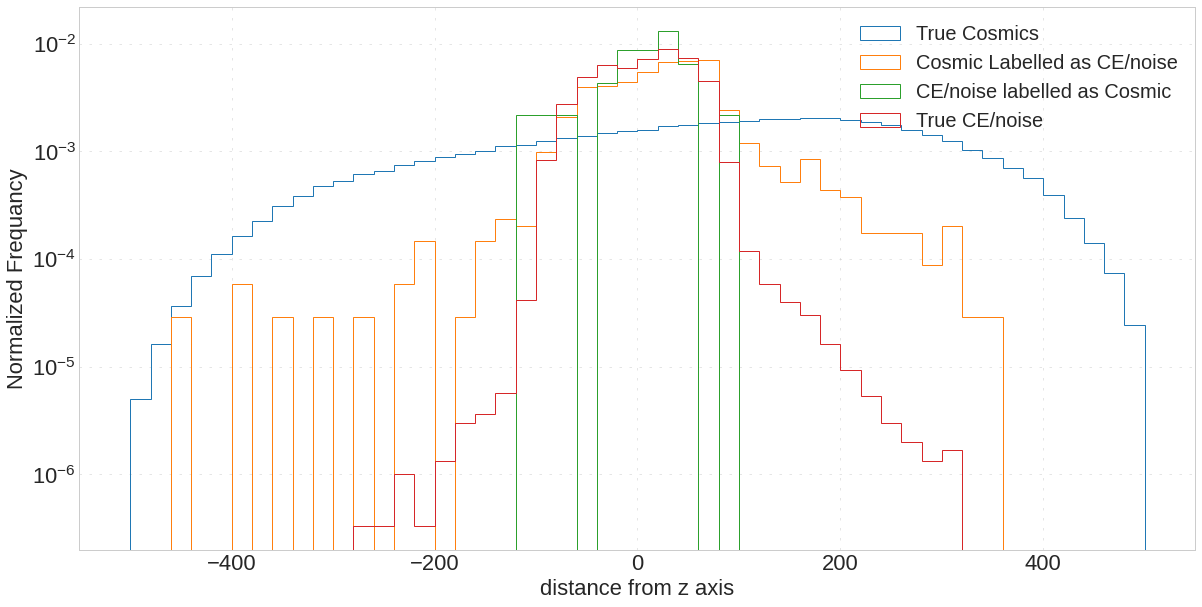

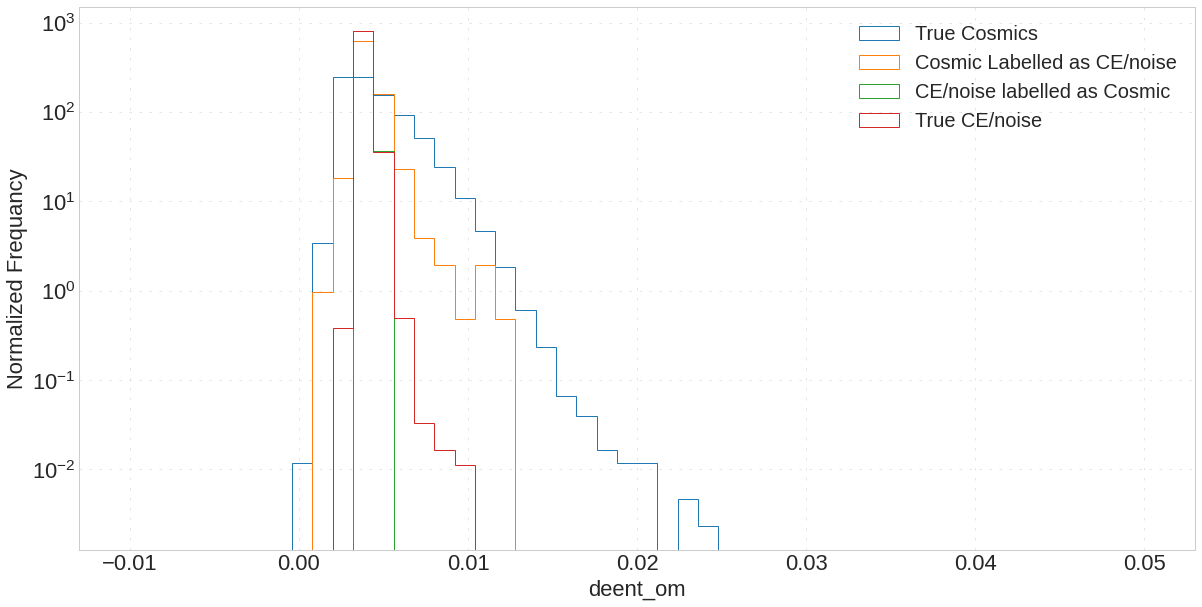

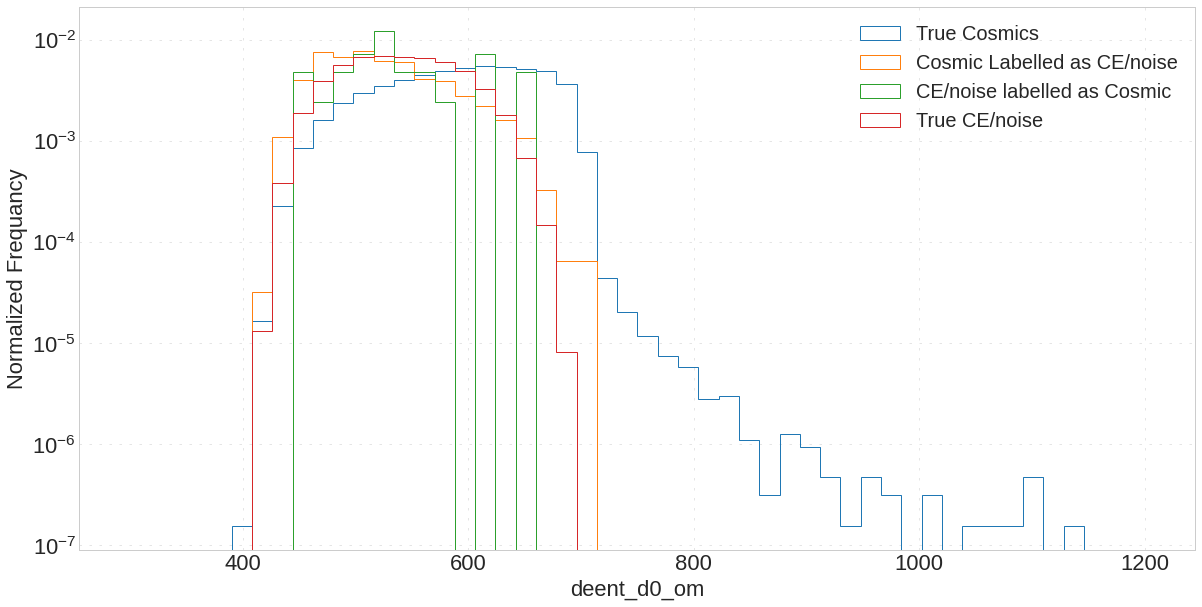

In [ ]:
CRVErrors = ErrorCalculations(CRV_X_test_df, CRV_all_preds, CRVrounded_predictions, CRV_y_test, dTZPE_noMom_variables_list)

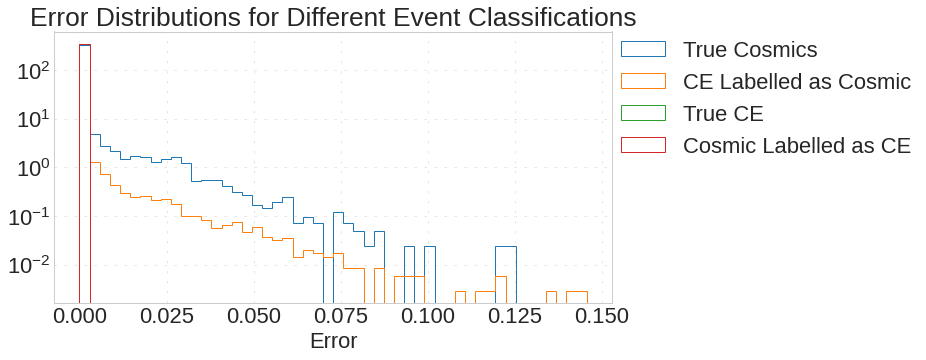

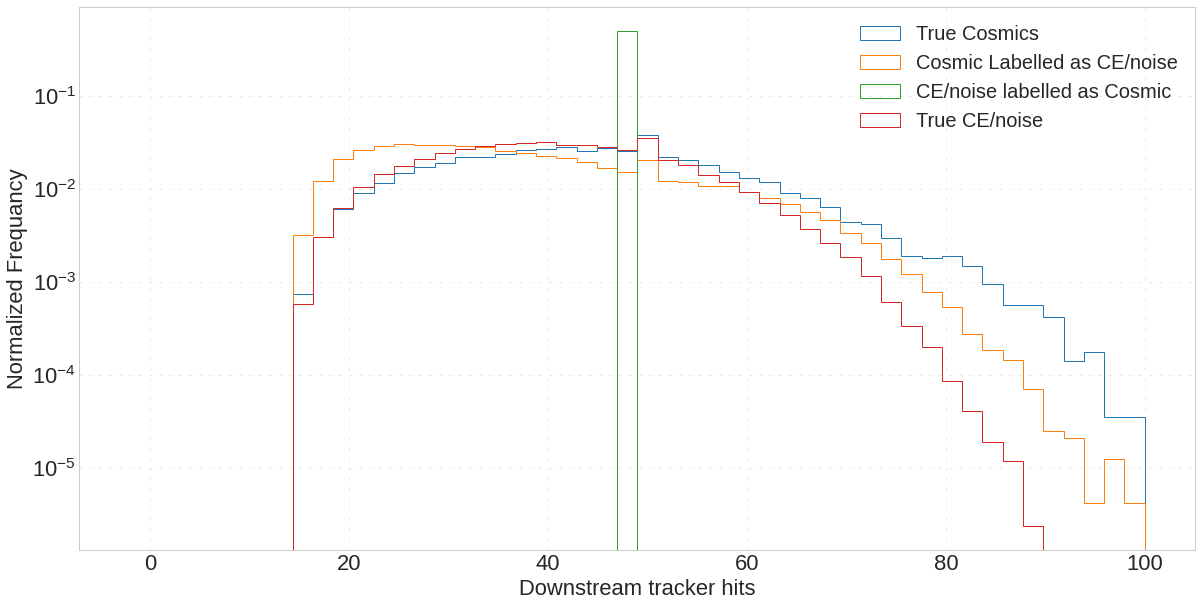

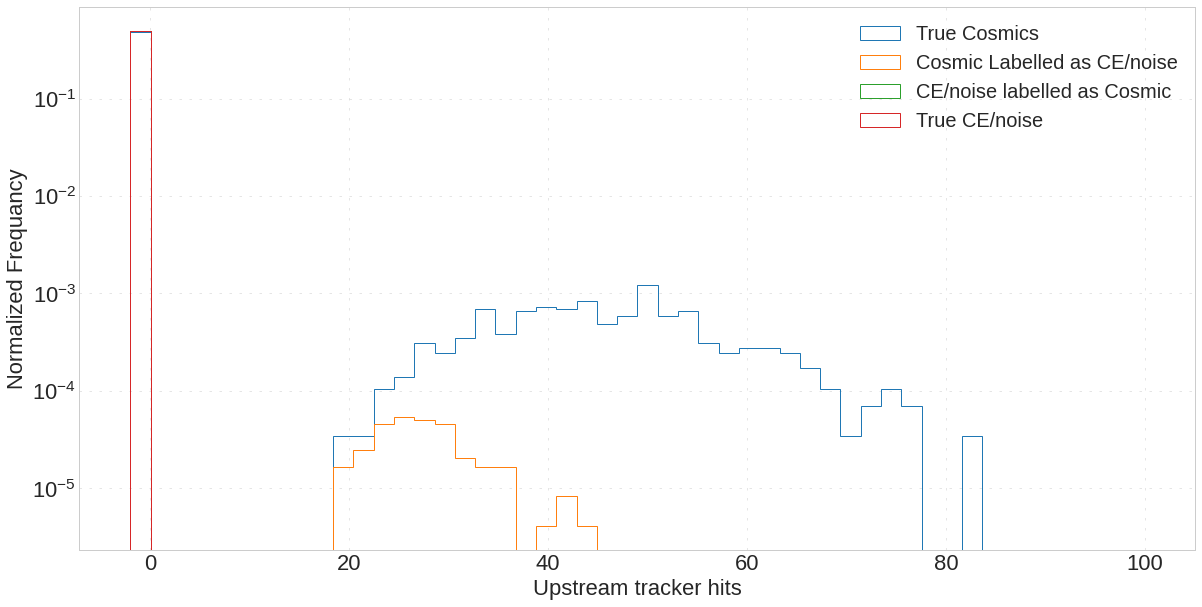

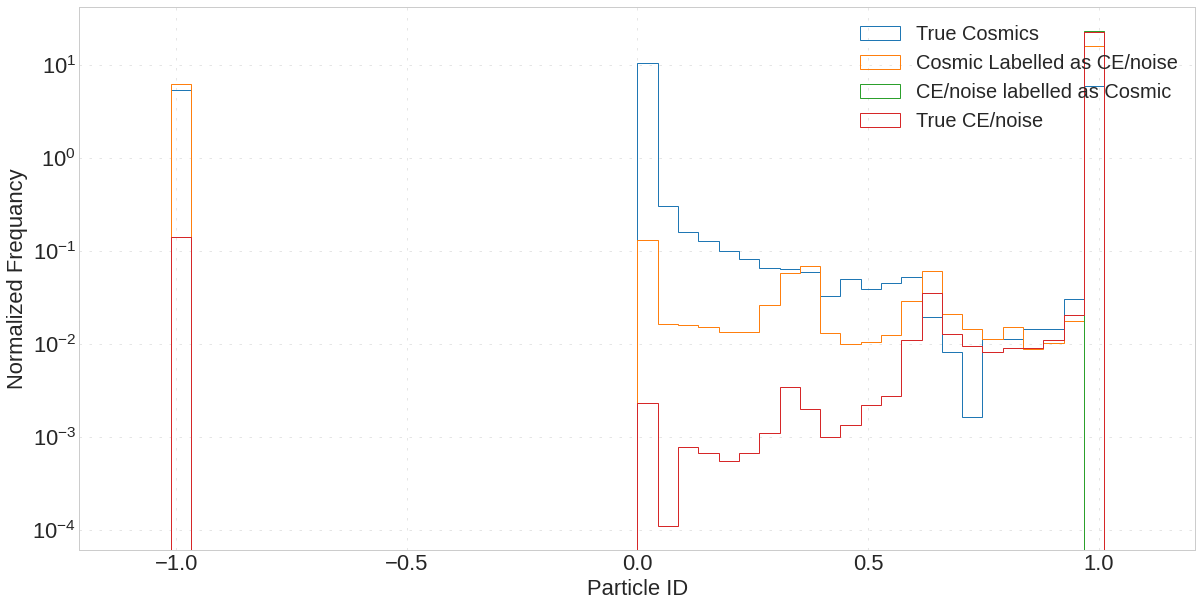

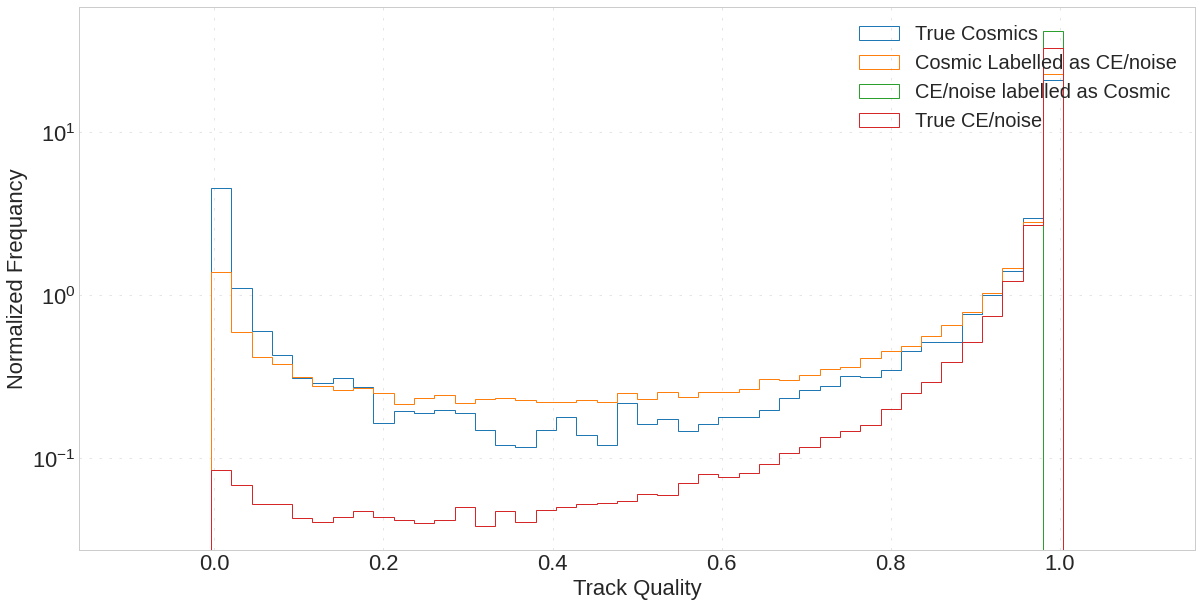

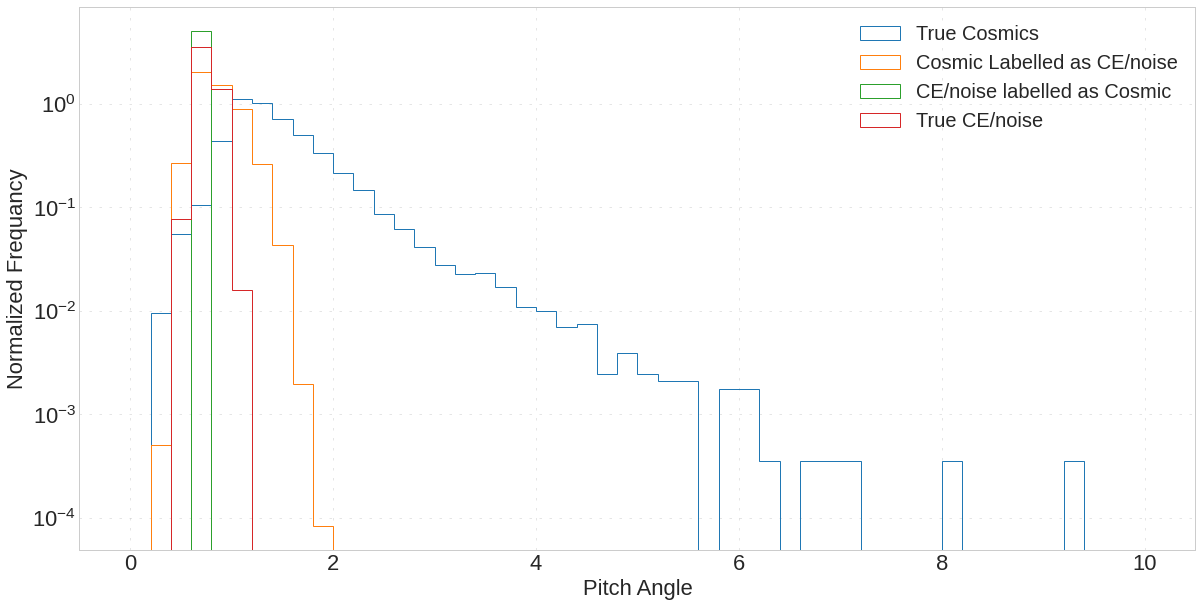

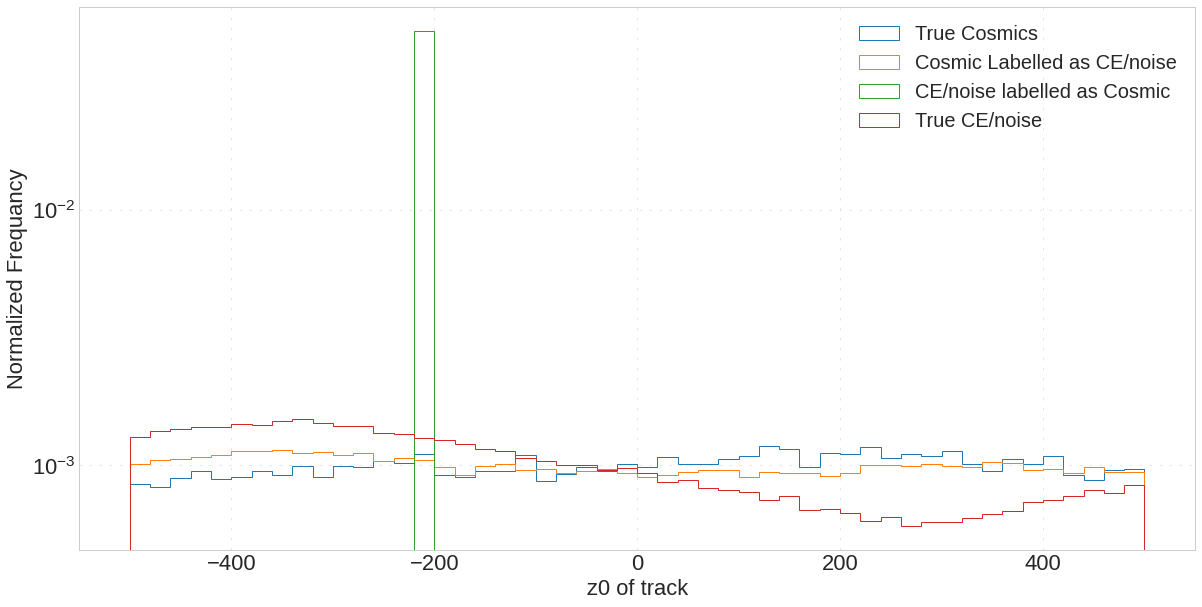

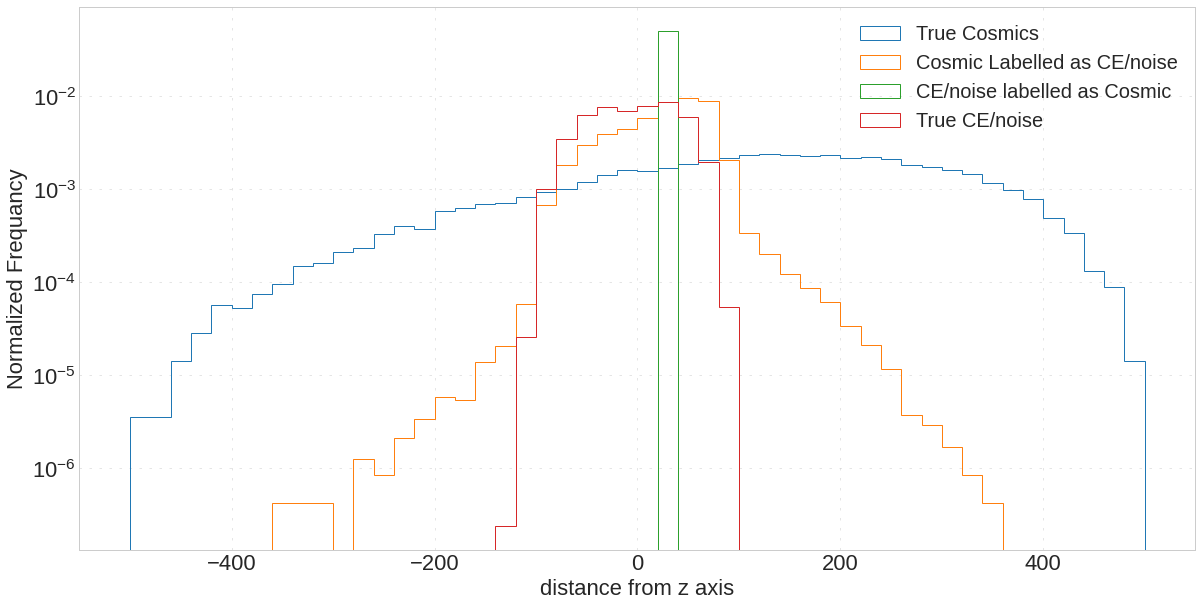

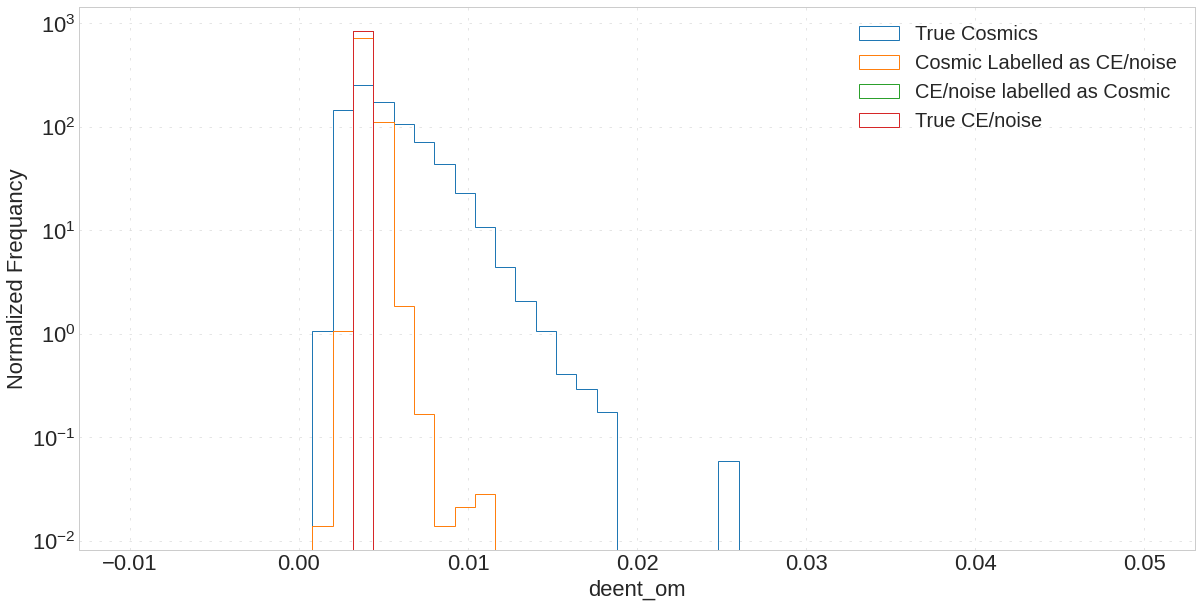

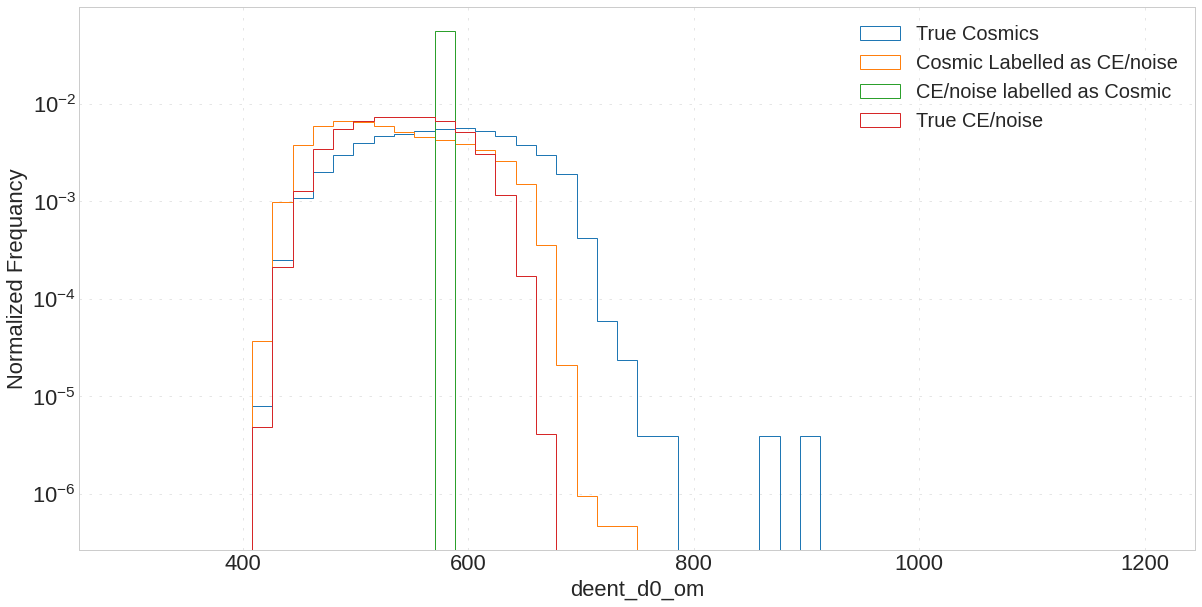

In [ ]:
NoCRVErrors = ErrorCalculations(no_CRV_X_test_df, NoCRV_all_preds, NoCRVrounded_predictions, no_CRV_y_test, noCRV_noMom_variables_list)

In [ ]:
# print("Using boundary conditions")
# print("Uncertainty for True Negatives")
# print(couldaMadeADifference(predictions, TNErrors, effs[0][0]),"\n")
# print("Uncertainty for False Negatives")
# print(couldaMadeADifference(predictions, FNErrors, effs[0][1]),"\n")
# print("Uncertainty for True Positives")
# print(couldaMadeADifference(predictions, TPErrors, effs[1][1]),"\n")
# print("Uncertainty for False Positives")
# print(couldaMadeADifference(predictions, FPErrors, effs[1][0]),"\n")
# print()
# print("Using variances")
# print("Uncertainty for True Negatives")
# print(np.var(list(TNErrors.values())) * effs[0][0], "\n")
# print("Uncertainty for False Negatives")
# print(np.var(list(FNErrors.values())) * effs[0][1], "\n")
# print("Uncertainty for True Positives")
# print(np.var(list(TPErrors.values())) * effs[1][1], "\n")
# print("Uncertainty for False Positives")
# print(np.var(list(FPErrors.values())) * effs[1][0], "\n")

In [ ]:
# categoryUncertainties = np.ceil(np.array([ [max(couldaMadeADifference(predictions, TNErrors, effs[0][0]), np.var(list(TNErrors.values()))*effs[0][0]), max(couldaMadeADifference(predictions, FPErrors, effs[1][0]), np.var(list(FPErrors.values()))*effs[1][0])],
#                           [max(couldaMadeADifference(predictions, FNErrors, effs[0][1]), np.var(list(FNErrors.values()))*effs[0][1]), max(couldaMadeADifference(predictions, TPErrors, effs[1][1]), np.var(list(TPErrors.values()))*effs[1][1])] ]))

In [ ]:
# nbins = 50
# upper_bound = max(max(TPErrors.values()), max(FPErrors.values()), max(TNErrors.values()), max(FNErrors.values()))
# plt.hist(TPErrors.values(), histtype='step', label="True Cosmics", bins=nbins, density = True, range=(0,upper_bound));
# plt.hist(FPErrors.values(), histtype='step', label="CE Labelled as Cosmic", bins=nbins, density = True, range=(0,upper_bound));
# plt.hist(TNErrors.values(), histtype='step', label="True CE", bins=nbins, density = True, range=(0,upper_bound));
# plt.hist(FNErrors.values(), histtype='step', label="Cosmic Labelled as CE", bins=nbins, density = True, range=(0,upper_bound));
# plt.legend(bbox_to_anchor=(1,1), loc="upper left", borderaxespad=0);
# plt.xlabel("Error")
# plt.title("Error Distributions for Different Event Classifications")
# plt.yscale('log');

In [ ]:
# possibleConfusions = 0
# for i in range(len(predictions)):
#   if abs(predictions[i] - cutoff) < AbsoluteErrors[i]:
#     possibleConfusions += 1
# print("Uncertainties could have changed", possibleConfusions, "events out of a total of", len(predictions), "events - affecting", possibleConfusions/len(predictions)*100, "\b% of events")

In [ ]:
def finalConfusion(eff, categoryUncertainty, percentage, cutoff):
  plt.figure(figsize=(10,7))

  newEffs = np.array([['0'*50,'0'*50],['0'*50,'0'*50]])
  counter = 0
  for i,j,z in zip(eff, categoryUncertainty, percentage):
    i = np.round(i)
    j = np.round(j)
    z = np.round(z,5)
    jj = np.round(j/(i[0]+i[1]),6)
    newEffs[counter][0] = str(i[0]) + " +/- " + str(j[0])
    newEffs[counter][0] += '\n(' + str(z[0]) + " +/- " + str('%.1e' %Decimal(jj[0])) + ')'
    newEffs[counter][1] = str(i[1]) + " +/- " + str(j[1])
    newEffs[counter][1] += '\n(' + str(z[1]) + " +/- " + str('%.1e' %Decimal(jj[1])) + ')'
    counter += 1

  ax = sns.heatmap(percentage, annot=newEffs, xticklabels=["CE/Noise", "cosmic"], yticklabels=["CE/Noise", "cosmic"], fmt='.50s', cbar_kws={'label': 'Fraction of Events'});
  
  ax.set(title="Confusion Matrix with Cutoff at " + str(round(cutoff, 5)),
        xlabel="Predicted Label",
        ylabel="True Label",);

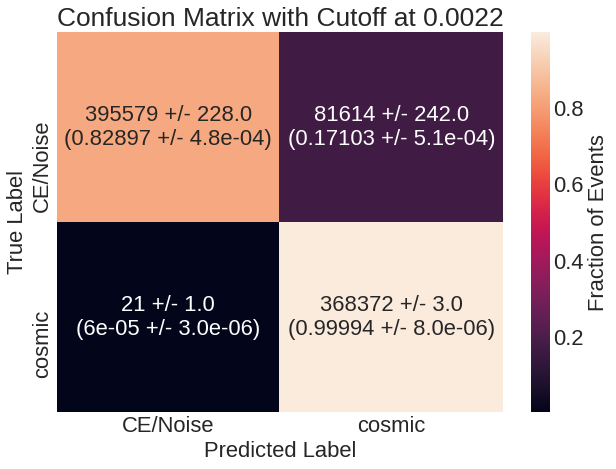

In [ ]:
finalConfusion(all_effs, categoryUncertainties, percentages, all_cutoff)

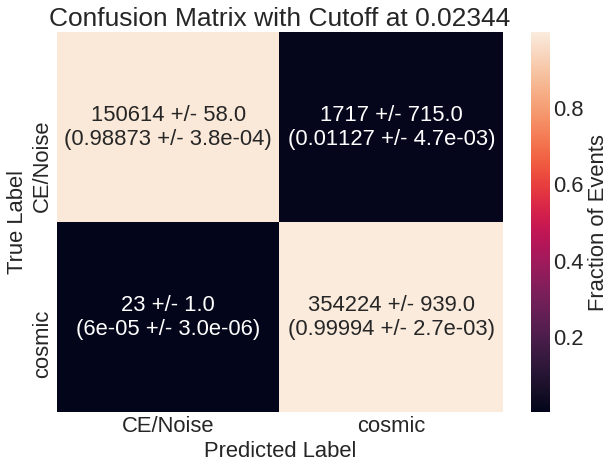

In [ ]:
finalConfusion(CRVeffs, CRVErrors, CRVpercentages, CRVcutoff)

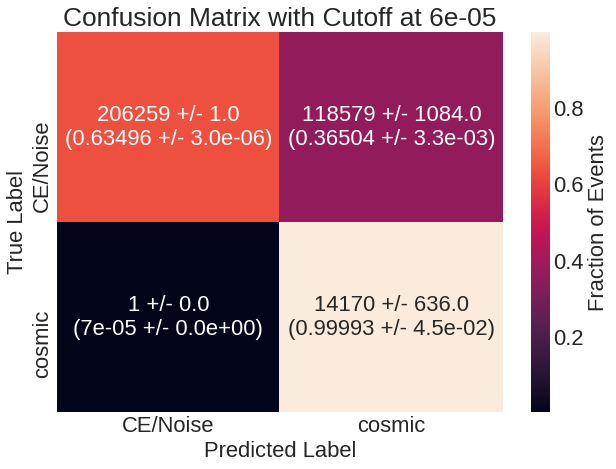

In [ ]:
finalConfusion(NoCRVeffs, NoCRVErrors, NoCRVpercentages, NoCRVcutoff)

#Analyzing Input Variables for Confusion Matrix Categories

In [ ]:
# TPInputs = pd.DataFrame(np.array(TPInputs), columns=list(variables_list.keys()))
# FPInputs = pd.DataFrame(np.array(FPInputs), columns=list(variables_list.keys()))
# FNInputs = pd.DataFrame(np.array(FNInputs), columns=list(variables_list.keys()))
# TNInputs = pd.DataFrame(np.array(TNInputs), columns=list(variables_list.keys()))

In [ ]:
# for var in variables_list:
#   try:
#     plt.figure(figsize=(20, 10))
#     plt.hist(TPInputs[var], histtype='step', label="True Cosmics", bins=nbins, density=True,  range=variables_list[var]);
#     plt.hist(FPInputs[var], histtype='step', label="Cosmic Labelled as CE/noise", bins=nbins, density=True,  range=variables_list[var]);
#     plt.hist(FNInputs[var], histtype='step', label="CE/noise labelled as Cosmic", bins=nbins, density=True,  range=variables_list[var]);
#     plt.hist(TNInputs[var], histtype='step', label="True CE/noise", bins=nbins, density=True,  range=variables_list[var]);
#     plt.xlabel(translation[var])
#     plt.yscale('log')
#     plt.ylabel('Normalized Frequancy')
#     plt.legend(prop={'size': 20})
#   except:
#     continue


#Training With All Variables

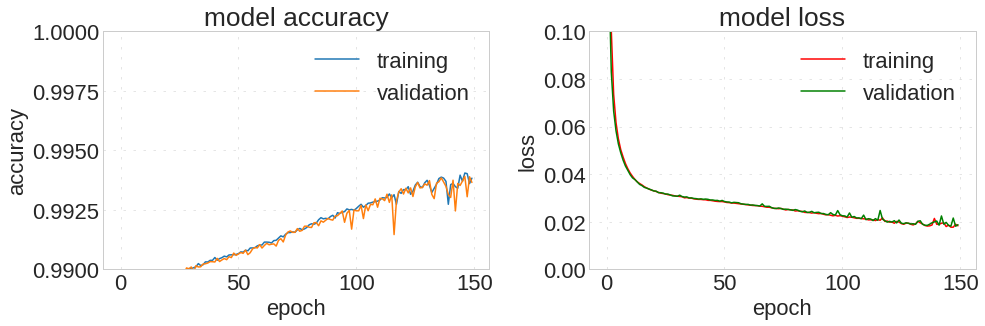

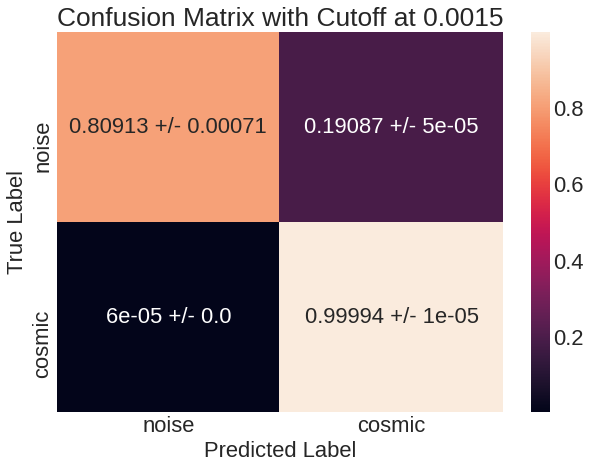

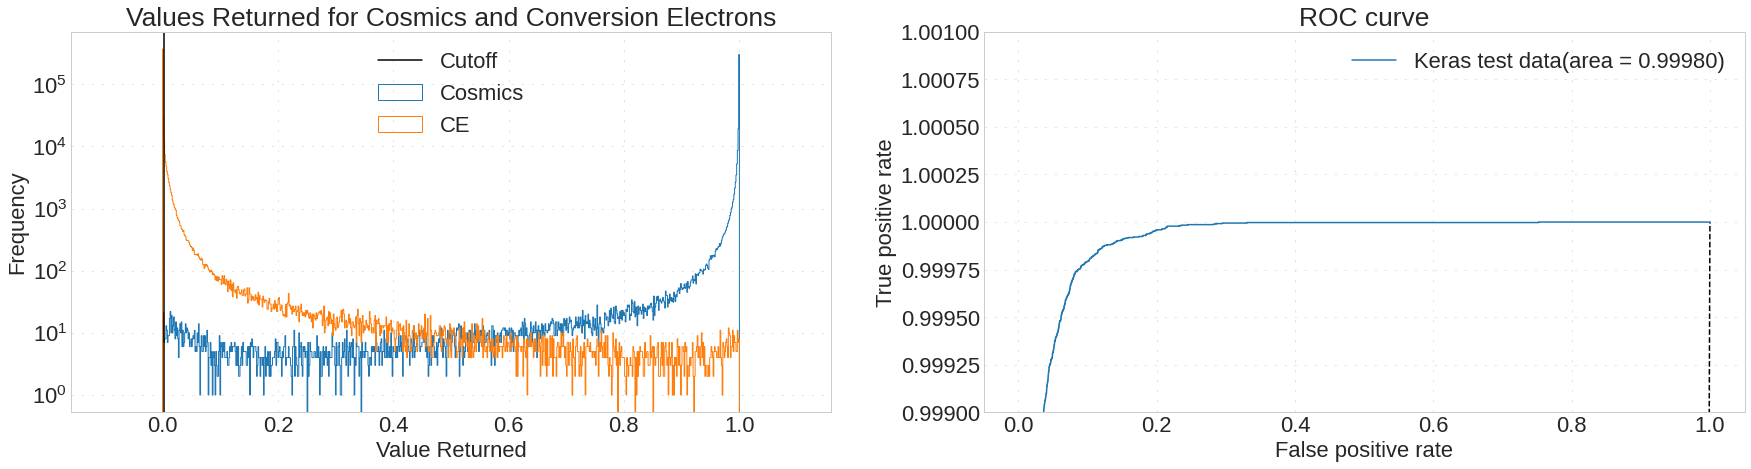

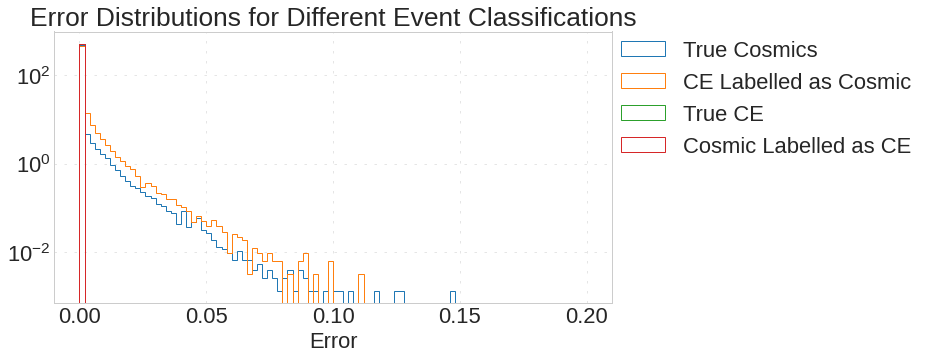

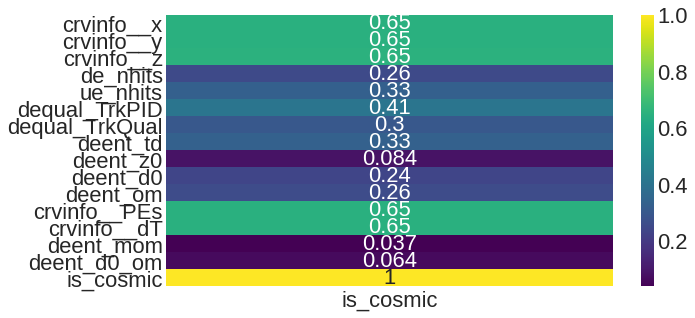

#Just dT

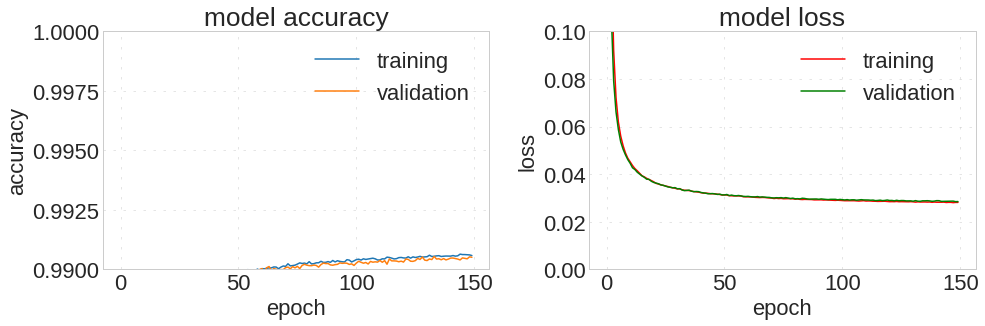

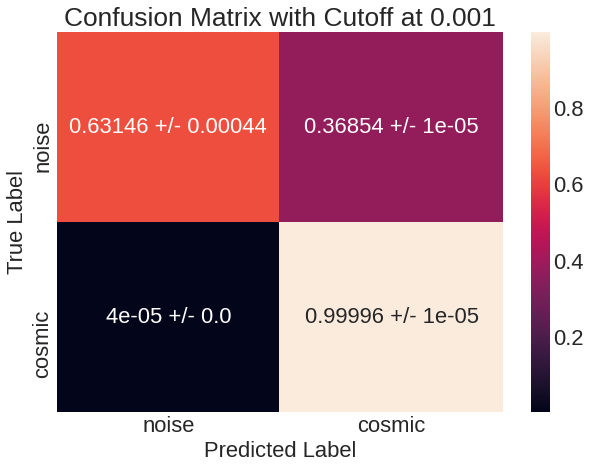

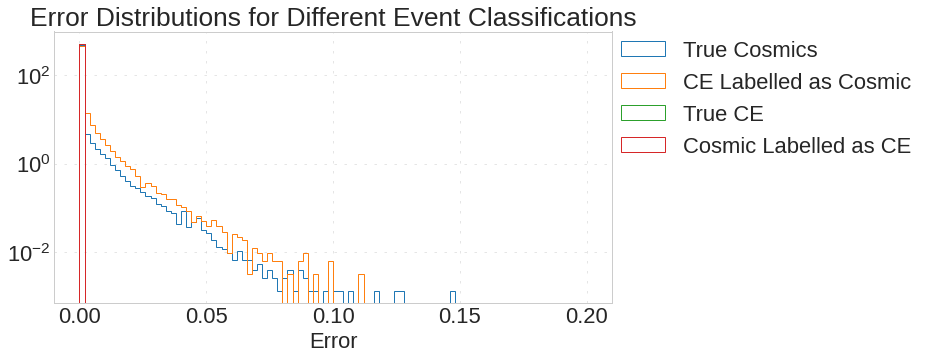

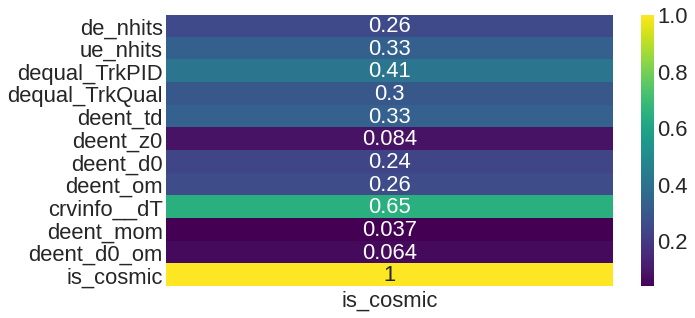

#Just Z

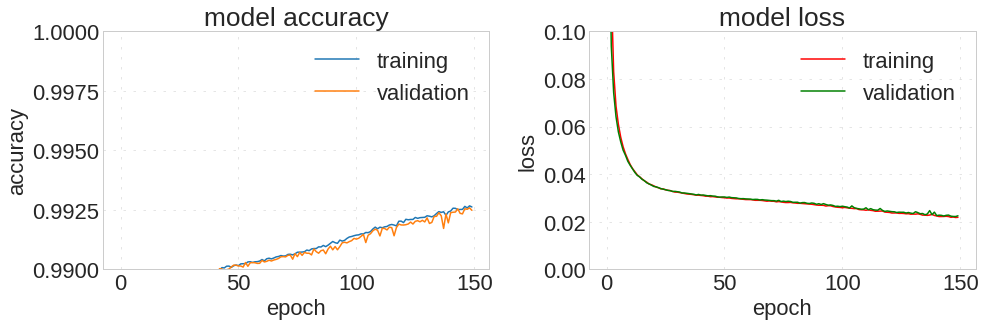

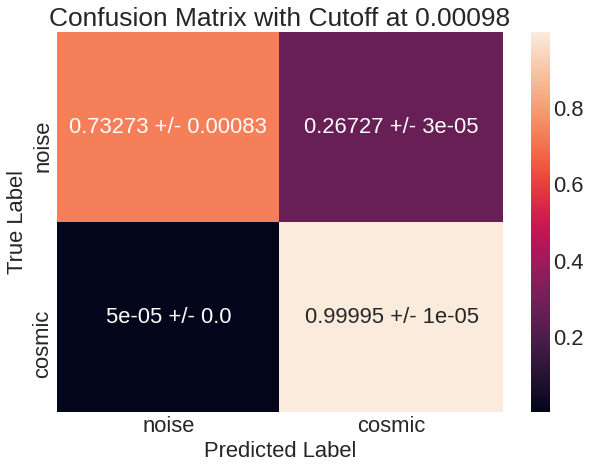

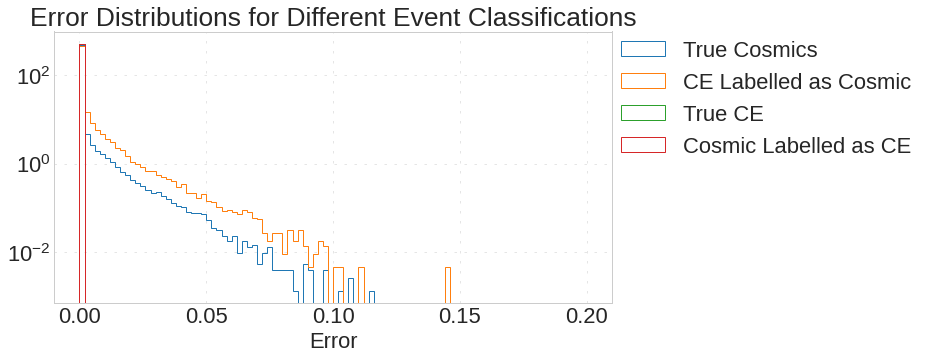

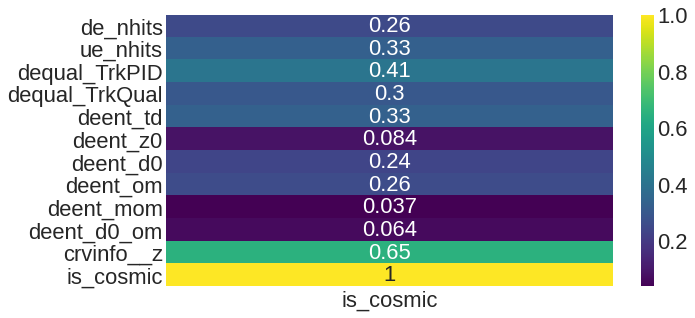

#dT & Z

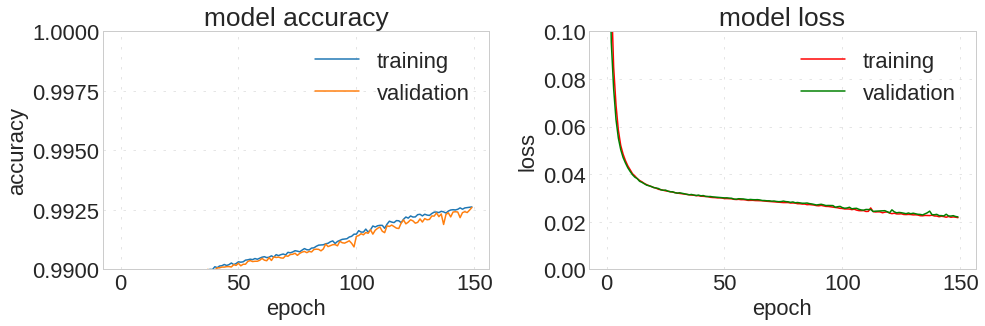

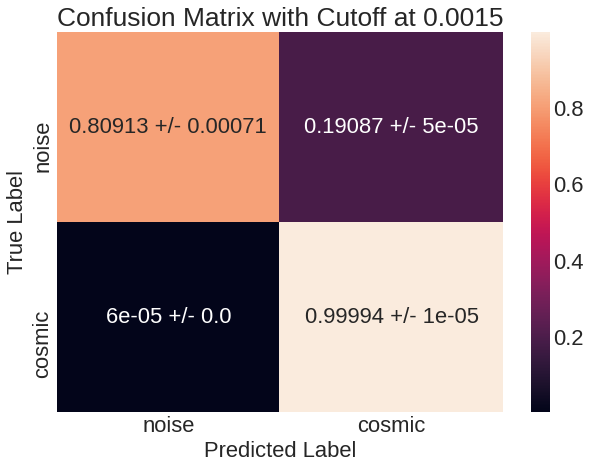

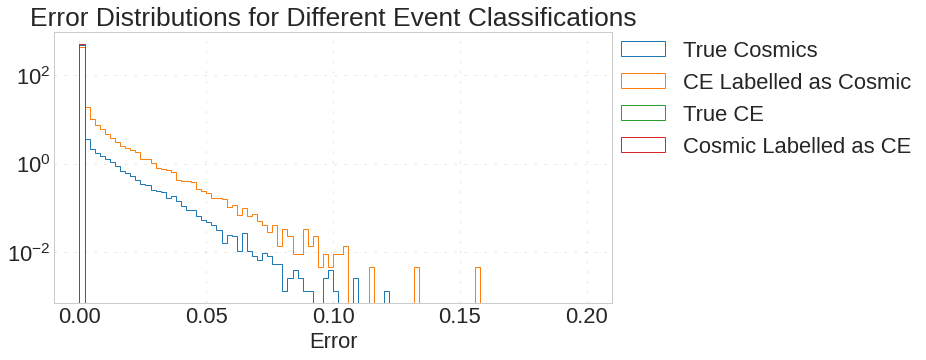

#All variables dropout=0.2

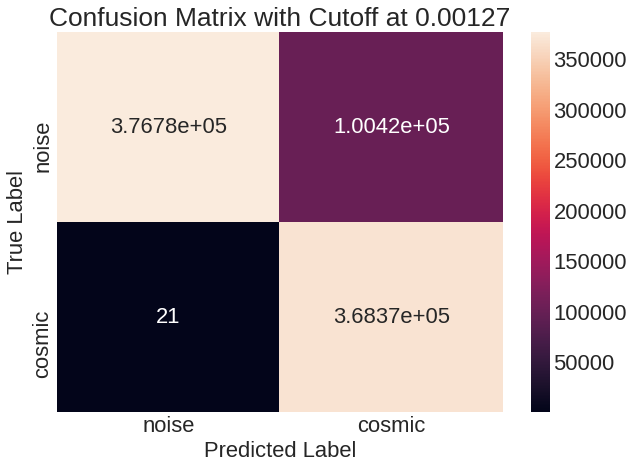

#All variables dropout=0.5

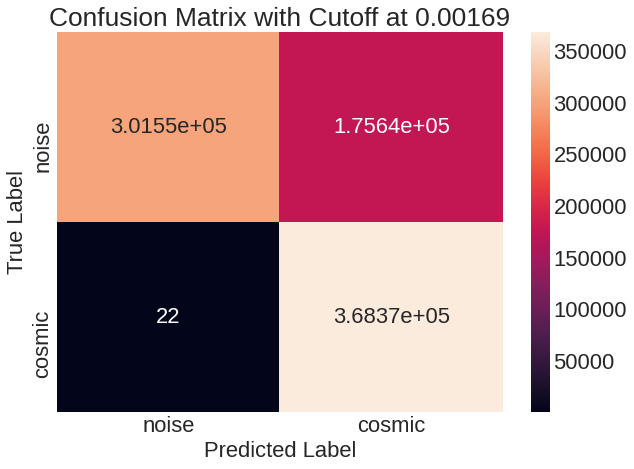

#Ignore

UndefinedVariableError: ignored

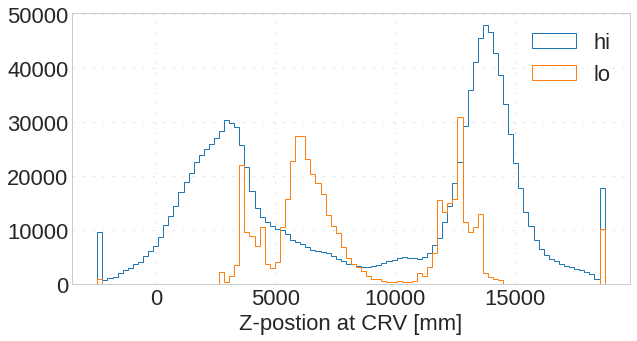

<Figure size 720x360 with 0 Axes>

In [ ]:
#@title Default title text
cuts_list = [cut_loose, cut_nomom, cut_extmom]

plt.hist(dfH['crvinfomc__z'], bins=100, histtype='step', label='hi');
plt.hist(dfL['crvinfomc__z'], bins=100, histtype='step', label='lo');
plt.xlabel('Z-postion at CRV [mm]')
plt.legend()

plt.figure()
for cut in cuts_list:
  plt.hist(dfH.query(cut)['crvinfomc__z'], bins=100, histtype='step', range=(-1000, 20000), density=True, label='cut');
plt.xlabel('Z-postion at CRV [mm]')
plt.legend()

plt.figure()
plt.hist(dfH.query(cut_loose)['crvinfomc__z'], bins=100, histtype='step', range=(-1000, 20000), density=True, label='loose cuts');
plt.hist(dfH.query(cut_nomom)['crvinfomc__z'], bins=100, histtype='step', range=(-1000, 20000), density=True, label='no mom');
plt.hist(dfH.query(cut_extmom)['crvinfomc__z'], bins=100, histtype='step', range=(-1000, 20000), density=True, label='ext mom');
#plt.hist(dfH.query(cut_box)['crvinfomc__z'], bins=100, histtype='step', range=(-1000, 20000), density=True, label='box');
plt.xlabel('Z-postion at CRV [mm]')
plt.legend()
plt.yscale('log')

plt.figure()
plt.hist(dfH.query(cut_loose)['crvinfomc__x'], bins=100, histtype='step', range=(-8000, 1000), density=True, label='loose cuts');
plt.hist(dfH.query(cut_nomom)['crvinfomc__x'], bins=100, histtype='step', range=(-8000, 1000), density=True, label='no mom cut');
plt.hist(dfH.query(cut_extmom)['crvinfomc__x'], bins=100, histtype='step', range=(-8000, 1000), density=True, label='mom cut');
plt.xlabel('X-postion at CRV [mm]')
plt.legend()

plt.figure()
plt.hist(dfH.query(cut_loose)['crvinfomc__y'], bins=100, histtype='step', range=(-2000, 2000), density=True, label='loose cuts');
plt.hist(dfH.query(cut_nomom)['crvinfomc__y'], bins=100, histtype='step', range=(-2000, 2000), density=True, label='no mom cut');
plt.hist(dfH.query(cut_extmom)['crvinfomc__y'], bins=100, histtype='step', range=(-2000, 2000), density=True, label='mom cut');
plt.xlabel('Y-postion at CRV [mm]')
plt.legend()

plt.figure()
plt.hist(dfH.query(cut_loose)['crvinfomc__parentE']/1000., bins=100, histtype='step', range=(0, 50), density=True, label='loose cuts');
plt.hist(dfH.query(cut_nomom)['crvinfomc__parentE']/1000., bins=100, histtype='step', range=(0, 50), density=True, label='no mom cut');
plt.hist(dfH.query(cut_extmom)['crvinfomc__parentE']/1000., bins=100, histtype='step', range=(0, 50), density=True, label='mom cut');
plt.xlabel('Primary energy[GeV]')
plt.legend()

#Legacy Code

In [ ]:
# keras.backend.clear_session() #This clears the previous training
# print("Model Summary")
# width = len(X_train[0])
# depth = 4
# keras.backend.clear_session()
# model = keras.Sequential()

# model.add(Dense(width, input_dim=width, activation='relu'))
# # model.add(Dropout(0.2))
# for i in range(depth):
#   model.add(Dense(2*width, activation='relu'))
#   model.add(Dropout(0.2))
# model.add(Dense(1, activation='sigmoid'))

# model.summary()
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# es_callback = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]
# print("fitting to the data...")
# #history = model.fit(x=X_train, y=y_train, epochs=100, batch_size=100000, callbacks=[es_callback], validation_split=0.2);
# history = model.fit(x=X_train, y=y_train, epochs=250, batch_size=100000, validation_split=0.2, verbose=False);

In [ ]:
# plt.plot(history.history['accuracy'], label="training")
# plt.plot(history.history['val_accuracy'], label="validation")
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(loc='best')
# plt.figure()

# plt.plot(history.history['loss'], label="training")
# plt.plot(history.history['val_loss'], label="validation")
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(loc='best')
# plt.show()

In [ ]:
# predictions = model.predict(X_test);

In [ ]:
# fig, ax = plt.subplots(1,2, figsize=(30,7))

# ax[0].hist(predictions[y_test==1], range=(-0.1,1.1), bins=1000, histtype='step', label='Cosmics')
# ax[0].hist(predictions[y_test==0], range=(-0.1,1.1), bins=1000, histtype='step', label='CE')
# ax[0].set_yscale('log')
# ax[0].legend(loc='upper center')

# fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, predictions);
# auc_keras = auc(fpr_keras, tpr_keras);
# ax[1].plot([0, 1], [0, 1], 'k--');
# ax[1].plot(fpr_keras, tpr_keras, label='Keras test data(area = {:.5f})'.format(auc_keras));
# ax[1].set_xlabel('False positive rate');
# ax[1].set_ylabel('True positive rate');
# # ax[1].set_yscale('log')
# # ax[1].set_xlim(0, 0.5)
# # ax[1].set_ylim(0.999, 1.0)
# #ax[1].set_ylim(0.95, 1.001)
# ax[1].set_title('ROC curve');
# ax[1].legend();

In [ ]:
# confusion = confusion_matrix(y_test, predictions.round(), normalize='true')
# sns.heatmap(confusion, annot=True, xticklabels=["noise", "cosmic"], yticklabels=["noise", "cosmic"], fmt='.4g')
# plt.xlabel("Predicted Label");
# plt.ylabel("True Label");

In [ ]:
# plt.hist(df_cut_nomom.query('crvinfo__y>-9999 & is_high==1')['crvinfomc__y'], bins=100, histtype='step', range=(-2100, 3100), density=True);
# plt.hist(df_cut_extmom.query('crvinfo__y>-9999 & is_high==1')['crvinfomc__y'], bins=100, histtype='step', range=(-2100, 3100), density=True);
# plt.yscale('log')
# plt.xlabel('Y-position at CRV')
# plt.figure()
# plt.hist(df_cut_nomom.query('crvinfo__y>-9999 & is_high==1')['crvinfomc__z'], bins=100, histtype='step', range=(-2000, 20000), density=True);
# plt.hist(df_cut_extmom.query('crvinfo__y>-9999 & is_high==1')['crvinfomc__z'], bins=100, histtype='step', range=(-2000, 20000), density=True);
# #plt.yscale('log')
# plt.figure()
# plt.hist(df_cut_nomom.query('crvinfo__y>-9999 & is_high==1')['crvinfomc__x'], bins=100, histtype='step', range=(-7000, 0), density=True);
# plt.hist(df_cut_extmom.query('crvinfo__y>-9999 & is_high==1')['crvinfomc__x'], bins=100, histtype='step', range=(-7000, 0), density=True);
# plt.yscale('log')